In [170]:
import psycopg2
from pymongo import MongoClient
from cassandra.cluster import Cluster
from cassandra import OperationTimedOut
import mysql.connector
import yaml
import pandas as pd
import os
import time
import sys
from pathlib import Path
import csv
import psutil
import statistics
from typing import List, Tuple, Callable, Set

with open('docker-compose.yaml', 'r') as file:
    docker_config = yaml.safe_load(file)

postgres_config = docker_config['services']['postgres']
postgres_client = psycopg2.connect(
    host='localhost',
    database=postgres_config['environment']['POSTGRES_DB'],
    user=postgres_config['environment']['POSTGRES_USER'],
    password=postgres_config['environment']['POSTGRES_PASSWORD'],
    port=postgres_config['ports'][0].split(':')[0]
)

mariadb_config = docker_config['services']['mariadb']
mariadb_client = mysql.connector.connect(
    host='localhost',
    database=mariadb_config['environment']['MYSQL_DATABASE'],
    user=mariadb_config['environment']['MYSQL_USER'],
    password=mariadb_config['environment']['MYSQL_PASSWORD'],
    port=mariadb_config['ports'][0].split(':')[0],
    allow_local_infile=True
)

mysql_config = docker_config['services']['mysql']
mysql_client = mysql.connector.connect(
    host='localhost',
    database=mysql_config['environment']['MYSQL_DATABASE'],
    user=mysql_config['environment']['MYSQL_USER'],
    password=mysql_config['environment']['MYSQL_PASSWORD'],
    port=mysql_config['ports'][0].split(':')[0],
    allow_local_infile=True
)

mongo_8_config = docker_config['services']['mongo-8']
mongo_8_client = MongoClient(
    host='localhost',
    port=int(mongo_8_config['ports'][0].split(':')[0]),
    username=mongo_8_config['environment']['MONGO_INITDB_ROOT_USERNAME'],
    password=mongo_8_config['environment']['MONGO_INITDB_ROOT_PASSWORD']
)

mongo_7_config = docker_config['services']['mongo-7']
mongo_7_client = MongoClient(
    host='localhost',
    port=int(mongo_7_config['ports'][0].split(':')[0]),
    username=mongo_7_config['environment']['MONGO_INITDB_ROOT_USERNAME'],
    password=mongo_7_config['environment']['MONGO_INITDB_ROOT_PASSWORD']
)

cassandra_config = docker_config['services']['cassandra']
cassandra_client = Cluster(['localhost'], port=int(cassandra_config['ports'][0].split(':')[0]))
cassandra_session = cassandra_client.connect()

try:
    postgres_client.cursor().execute("SELECT 0")
    mariadb_client.cursor(buffered=True).execute("SELECT 1")
    mysql_client.cursor(buffered=True).execute("SELECT 1")
    cassandra_session.execute("SELECT release_version FROM system.local")
    mongo_8_client.admin.command('ping')
    mongo_7_client.admin.command('ping')
    print("connection test - SUCCESS")
except Exception as e:
    print("connection test - FAILED")

connection test - SUCCESS


In [171]:
def initialize_postgres_schema(conn, schema):
    if not schema:
        return
    try:
        with conn.cursor() as cur:
            cur.execute(schema)
        conn.commit()
        print("PostgreSQL schema initialization complete.")
    except Exception as e:
        conn.rollback()
        print("Error initializing PostgreSQL schema")


def verify_postgres_tables(conn, expected_tables):
    try:
        with conn.cursor() as cur:
            cur.execute("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'public' AND table_name = ANY(%s);
            """, (expected_tables,))
            existing_tables = {row[0] for row in cur.fetchall()}

        missing_tables = set(expected_tables) - existing_tables
        if not missing_tables:
            print(f"INFO: All PostgreSQL tables exist: {', '.join(expected_tables)}")
            return True
        else:
            print(f"WARNING: Missing PostgreSQL tables: {', '.join(missing_tables)}")
            return False
    except Exception as e:
        print(f"ERROR: Error verifying PostgreSQL tables: {e}")
        return False



In [172]:
def initialize_mariadb_schema(conn, schema: str):
    if not schema:
        return
    try:
        cur = conn.cursor()
        # Rozdzielanie instrukcji po średnikach
        statements = schema.split(';')
        for statement in statements:
            stmt = statement.strip()
            if not stmt:
                continue
            cur.execute(stmt)
        
        conn.commit()
        print("MariaDB schema initialization complete.")
    except Exception as e:
        conn.rollback()
        print(f"Error initializing MariaDB schema: {e}")

def verify_mariadb_tables(conn, expected_tables):
    try:
        cur = conn.cursor()
        placeholders = ','.join(['%s'] * len(expected_tables))
        query = f"""
            SELECT table_name
            FROM information_schema.tables
            WHERE table_schema = DATABASE()
              AND table_name IN ({placeholders});
        """
        cur.execute(query, tuple(expected_tables))
        existing_tables = {row[0] for row in cur.fetchall()}

        missing_tables = set(expected_tables) - existing_tables
        if not missing_tables:
            print(f"INFO: All MariaDB tables exist: {', '.join(expected_tables)}")
            return True
        else:
            print(f"WARNING: Missing MariaDB tables: {', '.join(missing_tables)}")
            return False
    except Exception as e:
        print(f"ERROR: Error verifying MariaDB tables: {e}")
        return False

In [173]:
def initialize_mysql_schema(conn, schema: str):
    if not schema:
        return
    try:
        cur = conn.cursor()
        
        # opcjonalnie, jak chcesz mieć pewność że FK nie przeszkadzają przy DROP TABLE:
        # cur.execute("SET FOREIGN_KEY_CHECKS = 0;")
        
        statements = schema.split(';')
        for statement in statements:
            stmt = statement.strip()
            if not stmt:
                continue
            # debugowo możesz sobie wydrukować:
            # print("EXECUTING:", stmt)
            cur.execute(stmt)

        # cur.execute("SET FOREIGN_KEY_CHECKS = 1;")
        
        conn.commit()
        print("MySQL schema initialization complete.")
    except Exception as e:
        conn.rollback()
        print(f"Error initializing MySQL schema: {e}")



def verify_mysql_tables(conn, expected_tables):
    try:
        cur = conn.cursor()
        placeholders = ','.join(['%s'] * len(expected_tables))
        query = f"""
            SELECT table_name
            FROM information_schema.tables
            WHERE table_schema = DATABASE()
              AND table_name IN ({placeholders});
        """
        cur.execute(query, tuple(expected_tables))
        existing_tables = {row[0] for row in cur.fetchall()}

        missing_tables = set(expected_tables) - existing_tables
        if not missing_tables:
            print(f"INFO: All MySQL tables exist: {', '.join(expected_tables)}")
            return True
        else:
            print(f"WARNING: Missing MySQL tables: {', '.join(missing_tables)}")
            return False
    except Exception as e:
        print(f"ERROR: Error verifying MySQL tables: {e}")
        return False


In [174]:
from pymongo import ASCENDING

def initialize_mongodb_schema(db):
    """
    MongoDB jest schema-less, ale dla wydajności musimy utworzyć indeksy,
    które będą działać jak Primary Keys i Foreign Keys w SQL.
    """

    collections = ['titles', 'people', 'ratings', 'principals', 'aka_titles', 'episodes', 'title_genres']
    
    for col in collections:
        db[col].drop() # Czysty start
        
    print("MongoDB: Collections dropped. Creating indexes...")

    # Tworzenie indeksów (odpowiedniki PK i FK)
    db.titles.create_index([("tconst", ASCENDING)], unique=True)
    db.people.create_index([("nconst", ASCENDING)], unique=True)
    db.ratings.create_index([("title_id", ASCENDING)], unique=True)
    
    # Indeksy dla relacji (JOIN-ów)
    db.principals.create_index([("title_id", ASCENDING)])
    db.principals.create_index([("person_id", ASCENDING)])
    
    db.aka_titles.create_index([("title_id", ASCENDING)])
    
    db.episodes.create_index([("episode_id", ASCENDING)], unique=True)
    db.episodes.create_index([("parent_id", ASCENDING)])
    
    db.title_genres.create_index([("title_id", ASCENDING)])
    db.title_genres.create_index([("genre", ASCENDING)]) # Dla zapytań po gatunku
    
    print("MongoDB initialization complete.")

In [175]:
def initialize_cassandra_schema(session, schema: str):
    """
    Inicjalizuje schemę w Cassandrze (CQL).
    Przyjmuje aktywną sesję Cassandry oraz schemat CQL jako ciąg znaków.
    Wykonuje instrukcje CQL sekwencyjnie.
    """
    if not schema:
        return

    KEYSPACE_NAME = "imdb" # Zgodne z wygenerowanym schematem CQL

    try:
        # Dzielenie schematu na instrukcje na podstawie średnika (analiza analogiczna do MySQL [1]).
        statements = schema.split(';')
        
        for statement in statements:
            stmt = statement.strip()
            if not stmt:
                continue

            # Wykonanie instrukcji CQL
            session.execute(stmt)

        # Upewnienie się, że sesja używa poprawnego Keyspace po jego utworzeniu (instrukcja 'USE imdb;' 
        # powinna już być w schemacie, ale ta linia zapewnia spójność dla dalszych operacji).
        session.set_keyspace(KEYSPACE_NAME)
        
        print("Cassandra schema initialization complete.")
        
    except OperationTimedOut as e:
        print(f"Error initializing Cassandra schema: Operation timed out. Upewnij się, że klaster jest gotowy: {e}")
    except Exception as e:
        # Cassandra nie używa rollback, ale zgłasza błąd w przypadku problemów z CQL lub połączeniem.
        print(f"Error initializing Cassandra schema: {e}")

In [176]:
with open('db/postgres/schema.sql', 'r') as f:
    sql_schema = f.read()

postgres_tables = ['titles', 'aka_titles', 'ratings', 'people', 'principals', 'episodes', 'title_genres']

initialize_postgres_schema(postgres_client, sql_schema)
verify_postgres_tables(postgres_client, postgres_tables)

PostgreSQL schema initialization complete.
INFO: All PostgreSQL tables exist: titles, aka_titles, ratings, people, principals, episodes, title_genres


True

In [177]:
with open('db/mariadb/schema.sql', 'r') as f:
    mariadb_schema = f.read()

mariadb_tables = ['titles', 'aka_titles', 'ratings', 'people', 'principals', 'episodes', 'title_genres']

initialize_mariadb_schema(mariadb_client, mariadb_schema)
verify_mariadb_tables(mariadb_client, mariadb_tables)

MariaDB schema initialization complete.
INFO: All MariaDB tables exist: titles, aka_titles, ratings, people, principals, episodes, title_genres


True

In [178]:
with open('db/mysql/schema.sql', 'r') as f:
    mysql_schema = f.read()

mysql_tables = ['titles', 'aka_titles', 'ratings', 'people', 'principals', 'episodes', 'title_genres']

initialize_mysql_schema(mysql_client, mysql_schema)
verify_mysql_tables(mysql_client, mysql_tables)


MySQL schema initialization complete.
INFO: All MySQL tables exist: titles, aka_titles, ratings, people, principals, episodes, title_genres


True

In [179]:
mongo_8_client = mongo_8_client["imdb_benchmark"]
initialize_mongodb_schema(mongo_8_client)

MongoDB: Collections dropped. Creating indexes...
MongoDB initialization complete.


In [180]:
mongo_7_client = mongo_7_client["imdb_benchmark"]
initialize_mongodb_schema(mongo_7_client)

MongoDB: Collections dropped. Creating indexes...
MongoDB initialization complete.


In [181]:
cassandra_tables = ['titles', 'people', 'ratings_by_title', 'principals_by_title', 'aka_titles', 'episodes_by_series', 'title_genres_by_title', 'ratings_by_genre']

with open('db/cassandra/schema.cql', 'r') as f:
    cassandra_schema = f.read()

initialize_cassandra_schema(cassandra_session, cassandra_schema)

Cassandra schema initialization complete.


In [182]:
def postgres_operation(conn, query, fetch=False):
    try:
        with conn.cursor() as cur:
            cur.execute(query)
            if fetch:
                return cur.fetchall()
        if not fetch:
            conn.commit()
    except Exception as e:
        conn.rollback()
        print(f"Błąd operacji PostgreSQL: {e}")

In [183]:
def mariadb_operation(conn, query, fetch=False, params=None):
    try:
        cur = conn.cursor()
        if params is not None:
            cur.execute(query, params)
        else:
            cur.execute(query)

        if fetch:
            result = cur.fetchall()
        else:
            conn.commit()
            result = None

        cur.close()
        return result
    except Exception as e:
        conn.rollback()
        print(f"Błąd operacji MariaDB: {e}")
        return None

In [184]:
def mysql_operation(conn, query, fetch=False, params=None):
    try:
        cur = conn.cursor()
        if params is not None:
            cur.execute(query, params)
        else:
            cur.execute(query)

        if fetch:
            result = cur.fetchall()
        else:
            conn.commit()
            result = None

        cur.close()
        return result
    except Exception as e:
        conn.rollback()
        print(f"Błąd operacji MySQL: {e}")
        return None

In [185]:
def cassandra_operation(session, query, params=None, fetch=False):
    """
    Wykonuje operację Cassandra CQL.
    Brak transakcji, brak rollback – Cassandra zapisuje od razu (eventually consistent).
    """
    try:
        if params is not None:
            result = session.execute(query, params)
        else:
            result = session.execute(query)

        if fetch:
            return list(result)  # zamiana na listę dla kompatybilności z PG/MySQL
        return None
    except Exception as e:
        print(f"Błąd operacji Cassandra: {e}")
        return None


In [186]:
def load_insert_data_from_tsv(data_dir):
    data_path = Path(data_dir)
    result = {
        'titles': {},
        'people': {},
        'ratings': {},
        'principals': {},
        'aka_titles': {},
        'episodes': {},
        'title_genres': {}
    }
    
    # Helper to escape SQL strings
    def escape_sql(s):
        if s is None or s == '\\N':
            return None
        return str(s).replace("'", "''")
    
    # Load titles
    titles_file = data_path / 'titles.tsv'
    if titles_file.exists():
        with open(titles_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for i, row in enumerate(reader):
                tconst = row.get('tconst', '')
                if tconst:
                    result['titles'][tconst] = {
                        'title_type': escape_sql(row.get('title_type', '')),
                        'primary_title': escape_sql(row.get('primary_title', '')),
                        'original_title': escape_sql(row.get('original_title', '')),
                        'is_adult': row.get('is_adult', '0') == '1',
                        'start_year': row.get('start_year', '') if row.get('start_year') != '\\N' else None,
                        'end_year': row.get('end_year', '') if row.get('end_year') != '\\N' else None,
                        'runtime_minutes': row.get('runtime_minutes', '') if row.get('runtime_minutes') != '\\N' else None
                    }
    
    # Load people
    people_file = data_path / 'people.tsv'
    if people_file.exists():
        with open(people_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for i, row in enumerate(reader):
                nconst = row.get('nconst', '')
                if nconst:
                    result['people'][nconst] = {
                        'primary_name': escape_sql(row.get('primary_name', '')),
                        'birth_year': row.get('birth_year', '') if row.get('birth_year') != '\\N' else None,
                        'death_year': row.get('death_year', '') if row.get('death_year') != '\\N' else None,
                        'primary_profession': escape_sql(row.get('primary_profession', ''))
                    }
    
    # Load ratings
    ratings_file = data_path / 'ratings.tsv'
    if ratings_file.exists():
        with open(ratings_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for i, row in enumerate(reader):
                tconst = row.get('title_id', '')
                if tconst:
                    result['ratings'][tconst] = {
                        'average_rating': row.get('average_rating', '0'),
                        'num_votes': row.get('num_votes', '0')
                    }
    
    # Load principals
    principals_file = data_path / 'principals.tsv'
    if principals_file.exists():
        with open(principals_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for i, row in enumerate(reader):
                title_id = row.get('title_id', '')
                ordering = row.get('ordering', '')
                key = f"{title_id}_{ordering}"
                result['principals'][key] = {
                    'title_id': title_id,
                    'ordering': ordering,
                    'person_id': row.get('person_id', ''),
                    'category': escape_sql(row.get('category', '')),
                    'job': escape_sql(row.get('job', '')) if row.get('job') != '\\N' else None,
                    'characters': escape_sql(row.get('characters', '')) if row.get('characters') != '\\N' else None
                }

    # Load aka_titles
    aka_file = data_path / 'aka_titles.tsv'
    if aka_file.exists():
        with open(aka_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for i, row in enumerate(reader):
                title_id = row.get('title_id', '')
                ordering = row.get('ordering', '')
                key = f"{title_id}_{ordering}"
                result['aka_titles'][key] = {
                    'title_id': title_id,
                    'ordering': ordering,
                    'aka_title': escape_sql(row.get('aka_title', '')),
                    'region': escape_sql(row.get('region', '')) if row.get('region') != '\\N' else None,
                    'language': escape_sql(row.get('language', '')) if row.get('language') != '\\N' else None,
                    'types': escape_sql(row.get('types', '')) if row.get('types') != '\\N' else None,
                    'attributes': escape_sql(row.get('attributes', '')) if row.get('attributes') != '\\N' else None,
                    'is_original_title': row.get('is_original_title', '0') == '1'
                }
    
    # Load episodes
    episodes_file = data_path / 'episodes.tsv'
    if episodes_file.exists():
        with open(episodes_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for i, row in enumerate(reader):
                episode_id = row.get('episode_id', '')
                result['episodes'][episode_id] = {
                    'parent_id': row.get('parent_id', ''),
                    'season_number': row.get('season_number', '') if row.get('season_number') != '\\N' else None,
                    'episode_number': row.get('episode_number', '') if row.get('episode_number') != '\\N' else None
                }
    
    # Load title_genres
    genres_file = data_path / 'title_genres.tsv'
    if genres_file.exists():
        with open(genres_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for i, row in enumerate(reader):
                title_id = row.get('title_id', '')
                genre_value = row.get('genre', '')
                key = f"{title_id}_{genre_value}"
                result['title_genres'][key] = {
                    'title_id': title_id,
                    'genre': genre_value
                }    
    return result


In [187]:
INSERT_TITLE="INSERT Title ?"
INSERT_PERSON="INSERT Person ?"
INSERT_RATING="INSERT Rating ?"
INSERT_PRINCIPAL="INSERT Principal ?"
INSERT_AKA_TITLE="INSERT AKA Title ?"
INSERT_EPISODE="INSERT Episode ?"
INSERT_TITLE_GENRE="INSERT Title Genre ?"

SELECT_TITLE = "SELECT title ?"
SELECT_PERSON = "SELECT person ?"
SELECT_ALL_PEOPLE_IN_TITLE = "SELECT all people that are in the title ?"
SELECT_ALL_EPISODES_FOR_SERIES = "SELECT all episodes for the series ?"
SELECT_ALL_RATINGS_WITH_TITLE_INFO = "SELECT all ratings with title info for all titles in the genre ?"

UPDATE_TITLE_PRIMARY_TITLE = "UPDATE Title ? Primary Title"
UPDATE_ALL_RATINGS_FOR_TITLE = "UPDATE all Ratings for Title ?"
UPDATE_PERSON_PRIMARY_NAME = "UPDATE Person ? Primary Name"
UPDATE_TITLE_START_YEAR = "UPDATE Title ? Start Year"
UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE = "UPDATE Person Birth Year for all people that are in the title ?"

DELETE_TITLE = "DELETE Title ?"
DELETE_PERSON = "DELETE Person ?"
DELETE_GENRES_THAT_ARE_IN_THE_TITLE = "DELETE Genres that are in the title ?"
DELETE_PEOPLE_WHO_ARE_IN_TITLE = "DELETE People who are in title ?"

In [188]:
def load_postgres_data(conn, data_dir: str):
    data_path = Path(data_dir)

    def copy_from_tsv(conn, table_name, file_path, columns=None):
        op_time = time.time()
        f_op_time = time.time()

        try:
            with conn.cursor() as cur:
                with open(file_path, "r", encoding="utf-8") as f:
                    next(f)
                    f_op_time = time.time()

                    if columns:
                        cur.copy_from(f,
                            table_name,
                            columns=columns,
                            null="\\N",
                            sep="\t",
                        )
                    else:
                        cur.copy_from(
                            f,
                            table_name,
                            null="\\N",
                            sep="\t",
                        )
            conn.commit()
        except Exception as e:
            conn.rollback()
            print(f"ERROR loading {table_name} from {file_path}: {e}")
            raise

        end_time = time.time()
        return op_time, f_op_time, end_time

    # ---------- T I T L E S ----------
    titles_file = data_path / "titles.tsv"
    if titles_file.exists():
        op_time, f_op_time, end_time = copy_from_tsv(
            conn,
            "titles",
            titles_file,
            columns=(
                "tconst",
                "title_type",
                "primary_title",
                "original_title",
                "is_adult",
                "start_year",
                "end_year",
                "runtime_minutes",
            ),
        )
        print(
            f"INFO: Inserted titles in {end_time - op_time:.2f} s "
            f"(COPY phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {titles_file} not found, skipping titles")

    # ---------- P E O P L E ----------
    people_file = data_path / "people.tsv"
    if people_file.exists():
        op_time, f_op_time, end_time = copy_from_tsv(
            conn,
            "people",
            people_file,
            columns=(
                "nconst",
                "primary_name",
                "birth_year",
                "death_year",
                "primary_profession",
            ),
        )
        print(
            f"INFO: Inserted people in {end_time - op_time:.2f} s "
            f"(COPY phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {people_file} not found, skipping people")

    # ---------- R A T I N G S ----------
    ratings_file = data_path / "ratings.tsv"
    if ratings_file.exists():
        op_time, f_op_time, end_time = copy_from_tsv(
            conn,
            "ratings",
            ratings_file,
            columns=("title_id", "average_rating", "num_votes"),
        )
        print(
            f"INFO: Inserted ratings in {end_time - op_time:.2f} s "
            f"(COPY phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {ratings_file} not found, skipping ratings")

    # ---------- P R I N C I P A L S ----------
    principals_file = data_path / "principals.tsv"
    if principals_file.exists():
        op_time, f_op_time, end_time = copy_from_tsv(
            conn,
            "principals",
            principals_file,
            columns=("title_id", "ordering", "person_id", "category", "job", "characters"),
        )
        print(
            f"INFO: Inserted principals in {end_time - op_time:.2f} s "
            f"(COPY phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {principals_file} not found, skipping principals")

    # ---------- A K A _ T I T L E S ----------
    aka_titles_file = data_path / "aka_titles.tsv"
    if aka_titles_file.exists():
        op_time, f_op_time, end_time = copy_from_tsv(
            conn,
            "aka_titles",
            aka_titles_file,
            columns=(
                "title_id",
                "ordering",
                "aka_title",
                "region",
                "language",
                "types",
                "attributes",
                "is_original_title",
            ),
        )
        print(
            f"INFO: Inserted aka_titles in {end_time - op_time:.2f} s "
            f"(COPY phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {aka_titles_file} not found, skipping aka_titles")

    # ---------- E P I S O D E S ----------
    episodes_file = data_path / "episodes.tsv"
    if episodes_file.exists():
        op_time, f_op_time, end_time = copy_from_tsv(
            conn,
            "episodes",
            episodes_file,
            columns=("episode_id", "parent_id", "season_number", "episode_number"),
        )
        print(
            f"INFO: Inserted episodes in {end_time - op_time:.2f} s "
            f"(COPY phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {episodes_file} not found, skipping episodes")

    # ---------- T I T L E _ G E N R E S ----------
    title_genres_file = data_path / "title_genres.tsv"
    if title_genres_file.exists():
        op_time, f_op_time, end_time = copy_from_tsv(
            conn,
            "title_genres",
            title_genres_file,
            columns=("title_id", "genre"),
        )
        print(
            f"INFO: Inserted title_genres in {end_time - op_time:.2f} s "
            f"(COPY phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {title_genres_file} not found, skipping title_genres")

In [189]:
def load_mariadb_data(conn, data_dir: str):
    data_path = Path(data_dir)

    def load_from_tsv(conn, table_name, file_path, columns=None):
        op_time = time.time()
        f_op_time = time.time()

        try:
            cur = conn.cursor()
            file_path_str = str(file_path.resolve()).replace('\\', '/') # Fix for Windows paths in SQL

            base_query = f"""
                LOAD DATA LOCAL INFILE %s
                INTO TABLE {table_name}
                CHARACTER SET utf8mb4
                FIELDS TERMINATED BY '\\t'
                ESCAPED BY '\\\\'
                LINES TERMINATED BY '\\n'
                IGNORE 1 LINES
            """

            if columns:
                cols_sql = ", ".join(columns)
                query = base_query + f" ({cols_sql})"
            else:
                query = base_query

            f_op_time = time.time()
            cur.execute(query, (file_path_str,))
            conn.commit()
            cur.close()
        except Exception as e:
            conn.rollback()
            print(f"ERROR loading {table_name} from {file_path}: {e}")
            raise

        end_time = time.time()
        return op_time, f_op_time, end_time

    # Tabela mapująca nazwy plików na kolumny (skrócona wersja logiki z load_mysql_data)
    tables_config = {
        "titles": ("titles.tsv", ("tconst", "title_type", "primary_title", "original_title", "is_adult", "start_year", "end_year", "runtime_minutes")),
        "people": ("people.tsv", ("nconst", "primary_name", "birth_year", "death_year", "primary_profession")),
        "ratings": ("ratings.tsv", ("title_id", "average_rating", "num_votes")),
        "principals": ("principals.tsv", ("title_id", "ordering", "person_id", "category", "job", "characters")),
        "aka_titles": ("aka_titles.tsv", ("title_id", "ordering", "aka_title", "region", "language", "types", "attributes", "is_original_title")),
        "episodes": ("episodes.tsv", ("episode_id", "parent_id", "season_number", "episode_number")),
        "title_genres": ("title_genres.tsv", ("title_id", "genre"))
    }

    for table, (filename, cols) in tables_config.items():
        file_path = data_path / filename
        if file_path.exists():
            op_time, f_op_time, end_time = load_from_tsv(conn, table, file_path, columns=cols)
            print(f"INFO: Inserted {table} in {end_time - op_time:.2f} s (LOAD DATA phase: {end_time - f_op_time:.2f} s)")
        else:
            print(f"WARNING: {filename} not found, skipping {table}")

In [190]:
def load_mysql_data(conn, data_dir: str):
    data_path = Path(data_dir)

    def load_from_tsv(conn, table_name, file_path, columns=None):
        op_time = time.time()
        f_op_time = time.time()

        try:
            cur = conn.cursor()
            file_path_str = str(file_path.resolve())

            # baza opcji – TSV, \N jako NULL, pierwszy wiersz to nagłówek
            base_query = f"""
                LOAD DATA LOCAL INFILE %s
                INTO TABLE {table_name}
                CHARACTER SET utf8mb4
                FIELDS TERMINATED BY '\t'
                ESCAPED BY '\\\\'
                LINES TERMINATED BY '\n'
                IGNORE 1 LINES
            """

            if columns:
                cols_sql = ", ".join(columns)
                query = base_query + f" ({cols_sql})"
            else:
                query = base_query

            f_op_time = time.time()
            cur.execute(query, (file_path_str,))
            conn.commit()
            cur.close()
        except Exception as e:
            conn.rollback()
            print(f"ERROR loading {table_name} from {file_path}: {e}")
            raise

        end_time = time.time()
        return op_time, f_op_time, end_time

    # ---------- T I T L E S ----------
    titles_file = data_path / "titles.tsv"
    if titles_file.exists():
        op_time, f_op_time, end_time = load_from_tsv(
            conn,
            "titles",
            titles_file,
            columns=(
                "tconst",
                "title_type",
                "primary_title",
                "original_title",
                "is_adult",
                "start_year",
                "end_year",
                "runtime_minutes",
            ),
        )
        print(
            f"INFO: Inserted titles in {end_time - op_time:.2f} s "
            f"(LOAD DATA phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {titles_file} not found, skipping titles")

    # ---------- P E O P L E ----------
    people_file = data_path / "people.tsv"
    if people_file.exists():
        op_time, f_op_time, end_time = load_from_tsv(
            conn,
            "people",
            people_file,
            columns=(
                "nconst",
                "primary_name",
                "birth_year",
                "death_year",
                "primary_profession",
            ),
        )
        print(
            f"INFO: Inserted people in {end_time - op_time:.2f} s "
            f"(LOAD DATA phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {people_file} not found, skipping people")

    # ---------- R A T I N G S ----------
    ratings_file = data_path / "ratings.tsv"
    if ratings_file.exists():
        op_time, f_op_time, end_time = load_from_tsv(
            conn,
            "ratings",
            ratings_file,
            columns=("title_id", "average_rating", "num_votes"),
        )
        print(
            f"INFO: Inserted ratings in {end_time - op_time:.2f} s "
            f"(LOAD DATA phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {ratings_file} not found, skipping ratings")

    # ---------- P R I N C I P A L S ----------
    principals_file = data_path / "principals.tsv"
    if principals_file.exists():
        op_time, f_op_time, end_time = load_from_tsv(
            conn,
            "principals",
            principals_file,
            columns=("title_id", "ordering", "person_id", "category", "job", "characters"),
        )
        print(
            f"INFO: Inserted principals in {end_time - op_time:.2f} s "
            f"(LOAD DATA phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {principals_file} not found, skipping principals")

    # ---------- A K A _ T I T L E S ----------
    aka_titles_file = data_path / "aka_titles.tsv"
    if aka_titles_file.exists():
        op_time, f_op_time, end_time = load_from_tsv(
            conn,
            "aka_titles",
            aka_titles_file,
            columns=(
                "title_id",
                "ordering",
                "aka_title",
                "region",
                "language",      # tu musi być dokładnie tak jak w schemacie MySQL
                "types",
                "attributes",
                "is_original_title",
            ),
        )
        print(
            f"INFO: Inserted aka_titles in {end_time - op_time:.2f} s "
            f"(LOAD DATA phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {aka_titles_file} not found, skipping aka_titles")

    # ---------- E P I S O D E S ----------
    episodes_file = data_path / "episodes.tsv"
    if episodes_file.exists():
        op_time, f_op_time, end_time = load_from_tsv(
            conn,
            "episodes",
            episodes_file,
            columns=("episode_id", "parent_id", "season_number", "episode_number"),
        )
        print(
            f"INFO: Inserted episodes in {end_time - op_time:.2f} s "
            f"(LOAD DATA phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {episodes_file} not found, skipping episodes")

    # ---------- T I T L E _ G E N R E S ----------
    title_genres_file = data_path / "title_genres.tsv"
    if title_genres_file.exists():
        op_time, f_op_time, end_time = load_from_tsv(
            conn,
            "title_genres",
            title_genres_file,
            columns=("title_id", "genre"),
        )
        print(
            f"INFO: Inserted title_genres in {end_time - op_time:.2f} s "
            f"(LOAD DATA phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {title_genres_file} not found, skipping title_genres")


In [191]:
def load_mongodb_data(db, data_dir: str):
    data_path = Path(data_dir)
    
    # Mapowanie nazw plików na kolekcje i typy danych
    # Funkcja pomocnicza do konwersji typów z TSV (wszystko jest stringiem) na typy Mongo
    def convert_row(row, int_cols=[], float_cols=[], bool_cols=[]):
        new_row = row.copy()
        for col in int_cols:
            if new_row.get(col) and new_row[col] != '\\N':
                try: new_row[col] = int(new_row[col])
                except: new_row[col] = None
            else: new_row[col] = None
            
        for col in float_cols:
            if new_row.get(col) and new_row[col] != '\\N':
                try: new_row[col] = float(new_row[col])
                except: new_row[col] = None
            else: new_row[col] = None
            
        for col in bool_cols:
            if new_row.get(col):
                new_row[col] = True if new_row[col] == '1' or new_row[col] == 'True' else False
        return new_row

    # Konfiguracja kolumn dla każdej kolekcji
    tables_config = {
        "titles": {
            "file": "titles.tsv", 
            "int_cols": ["start_year", "end_year", "runtime_minutes"], 
            "bool_cols": ["is_adult"]
        },
        "people": {
            "file": "people.tsv", 
            "int_cols": ["birth_year", "death_year"]
        },
        "ratings": {
            "file": "ratings.tsv", 
            "float_cols": ["average_rating"], 
            "int_cols": ["num_votes"]
        },
        "principals": {
            "file": "principals.tsv", 
            "int_cols": ["ordering"]
        },
        "aka_titles": {
            "file": "aka_titles.tsv", 
            "int_cols": ["ordering"], 
            "bool_cols": ["is_original_title"]
        },
        "episodes": {
            "file": "episodes.tsv", 
            "int_cols": ["season_number", "episode_number"]
        },
        "title_genres": {
            "file": "title_genres.tsv"
        }
    }

    import csv
    
    for col_name, config in tables_config.items():
        file_path = data_path / config["file"]
        if not file_path.exists():
            print(f"WARNING: {config['file']} not found, skipping.")
            continue
            
        op_time = time.time()
        
        batch_size = 10000
        batch = []
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                reader = csv.DictReader(f, delimiter='\t')
                for row in reader:
                    # Konwersja typów
                    doc = convert_row(row, 
                                      int_cols=config.get("int_cols", []),
                                      float_cols=config.get("float_cols", []),
                                      bool_cols=config.get("bool_cols", []))
                    batch.append(doc)
                    
                    if len(batch) >= batch_size:
                        db[col_name].insert_many(batch)
                        batch = []
                
                # Insert resztek
                if batch:
                    db[col_name].insert_many(batch)
                    
            print(f"INFO: Inserted {col_name} into MongoDB in {time.time() - op_time:.2f} s")
            
        except Exception as e:
            print(f"ERROR loading {col_name} to MongoDB: {e}")

In [192]:
def load_cassandra_data(session, data_dir: str):
    data_path = Path(data_dir)

    def parse_int(v):
        return int(v) if v not in (None, "", "\\N") else None

    def parse_float(v):
        return float(v) if v not in (None, "", "\\N") else None

    def parse_bool(v):
        if v in ("0", 0, "False", "false", "\\N", None, ""):
            return False
        if v in ("1", 1, "True", "true"):
            return True
        return None

    # ---------- T I T L E S ----------
    titles_file = data_path / "titles.tsv"
    if titles_file.exists():
        op_time = time.time()
        insert_stmt = session.prepare("""
            INSERT INTO imdb.titles (
                tconst, title_type, primary_title, original_title,
                is_adult, start_year, end_year, runtime_minutes
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """)

        f_op_time = time.time()
        with open(titles_file, "r", encoding="utf-8") as f:
            next(f)  # skip header
            for line in f:
                cols = line.rstrip("\n").split("\t")
                session.execute(insert_stmt, (
                    cols[0],                     # tconst
                    cols[1],                     # title_type
                    cols[2],                     # primary_title
                    cols[3],                     # original_title
                    parse_bool(cols[4]),         # is_adult
                    parse_int(cols[5]),          # start_year
                    parse_int(cols[6]),          # end_year
                    parse_int(cols[7]),          # runtime_minutes
                ))

        end_time = time.time()
        print(
            f"INFO: Inserted titles in {end_time - op_time:.2f} s "
            f"(INSERT phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {titles_file} not found, skipping titles")

    # ---------- P E O P L E ----------
    people_file = data_path / "people.tsv"
    if people_file.exists():
        op_time = time.time()
        insert_stmt = session.prepare("""
            INSERT INTO imdb.people (
                nconst, primary_name, birth_year, death_year, primary_profession
            ) VALUES (?, ?, ?, ?, ?)
        """)

        f_op_time = time.time()
        with open(people_file, "r", encoding="utf-8") as f:
            next(f)
            for line in f:
                cols = line.rstrip("\n").split("\t")
                session.execute(insert_stmt, (
                    cols[0],                     # nconst
                    cols[1],                     # primary_name
                    parse_int(cols[2]),          # birth_year
                    parse_int(cols[3]),          # death_year
                    cols[4] if cols[4] != "\\N" else None,  # primary_profession
                ))

        end_time = time.time()
        print(
            f"INFO: Inserted people in {end_time - op_time:.2f} s "
            f"(INSERT phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {people_file} not found, skipping people")

    # ---------- R A T I N G S ----------
    ratings_file = data_path / "ratings.tsv"
    if ratings_file.exists():
        op_time = time.time()
        insert_stmt = session.prepare("""
            INSERT INTO imdb.ratings (
                title_id, average_rating, num_votes
            ) VALUES (?, ?, ?)
        """)

        f_op_time = time.time()
        with open(ratings_file, "r", encoding="utf-8") as f:
            next(f)
            for line in f:
                cols = line.rstrip("\n").split("\t")
                session.execute(insert_stmt, (
                    cols[0],                     # title_id
                    parse_float(cols[1]),        # average_rating
                    parse_int(cols[2]),          # num_votes
                ))

        end_time = time.time()
        print(
            f"INFO: Inserted ratings in {end_time - op_time:.2f} s "
            f"(INSERT phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {ratings_file} not found, skipping ratings")

    # ---------- P R I N C I P A L S ----------
    principals_file = data_path / "principals.tsv"
    if principals_file.exists():
        op_time = time.time()
        insert_stmt = session.prepare("""
            INSERT INTO imdb.principals (
                title_id, ordering, person_id, category, job, characters
            ) VALUES (?, ?, ?, ?, ?, ?)
        """)

        f_op_time = time.time()
        with open(principals_file, "r", encoding="utf-8") as f:
            next(f)
            for line in f:
                cols = line.rstrip("\n").split("\t")
                session.execute(insert_stmt, (
                    cols[0],                                 # title_id
                    parse_int(cols[1]),                      # ordering
                    cols[2],                                 # person_id
                    cols[3],                                 # category
                    cols[4] if cols[4] != "\\N" else None,   # job
                    cols[5] if cols[5] != "\\N" else None,   # characters
                ))

        end_time = time.time()
        print(
            f"INFO: Inserted principals in {end_time - op_time:.2f} s "
            f"(INSERT phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {principals_file} not found, skipping principals")

    # ---------- A K A _ T I T L E S ----------
    aka_titles_file = data_path / "aka_titles.tsv"
    if aka_titles_file.exists():
        op_time = time.time()
        insert_stmt = session.prepare("""
            INSERT INTO imdb.aka_titles (
                title_id, ordering, aka_title, region, language,
                types, attributes, is_original_title
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """)

        f_op_time = time.time()
        with open(aka_titles_file, "r", encoding="utf-8") as f:
            next(f)
            for line in f:
                cols = line.rstrip("\n").split("\t")
                session.execute(insert_stmt, (
                    cols[0],                                 # title_id
                    parse_int(cols[1]),                      # ordering
                    cols[2],                                 # aka_title
                    cols[3] if cols[3] != "\\N" else None,   # region
                    cols[4] if cols[4] != "\\N" else None,   # language
                    cols[5] if cols[5] != "\\N" else None,   # types
                    cols[6] if cols[6] != "\\N" else None,   # attributes
                    parse_bool(cols[7]),                     # is_original_title
                ))

        end_time = time.time()
        print(
            f"INFO: Inserted aka_titles in {end_time - op_time:.2f} s "
            f"(INSERT phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {aka_titles_file} not found, skipping aka_titles")

    # ---------- E P I S O D E S ----------
    episodes_file = data_path / "episodes.tsv"
    if episodes_file.exists():
        op_time = time.time()
        insert_stmt = session.prepare("""
            INSERT INTO imdb.episodes (
                episode_id, parent_id, season_number, episode_number
            ) VALUES (?, ?, ?, ?)
        """)

        f_op_time = time.time()
        with open(episodes_file, "r", encoding="utf-8") as f:
            next(f)
            for line in f:
                cols = line.rstrip("\n").split("\t")
                session.execute(insert_stmt, (
                    cols[0],                     # episode_id
                    cols[1],                     # parent_id
                    parse_int(cols[2]),          # season_number
                    parse_int(cols[3]),          # episode_number
                ))

        end_time = time.time()
        print(
            f"INFO: Inserted episodes in {end_time - op_time:.2f} s "
            f"(INSERT phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {episodes_file} not found, skipping episodes")

    # ---------- T I T L E _ G E N R E S ----------
    title_genres_file = data_path / "title_genres.tsv"
    if title_genres_file.exists():
        op_time = time.time()
        insert_stmt = session.prepare("""
            INSERT INTO imdb.title_genres (
                title_id, genre
            ) VALUES (?, ?)
        """)

        f_op_time = time.time()
        with open(title_genres_file, "r", encoding="utf-8") as f:
            next(f)
            for line in f:
                cols = line.rstrip("\n").split("\t")
                session.execute(insert_stmt, (
                    cols[0],     # title_id
                    cols[1],     # genre
                ))

        end_time = time.time()
        print(
            f"INFO: Inserted title_genres in {end_time - op_time:.2f} s "
            f"(INSERT phase: {end_time - f_op_time:.2f} s)"
        )
    else:
        print(f"WARNING: {title_genres_file} not found, skipping title_genres")


In [193]:
class BenchmarkTime:    
    def __init__(self, db_type: str, data_dir: str):
        self.data_dir = data_dir
        self.db_type = db_type
        self.process = psutil.Process()
        self.results = []
    
    def get_results_df(self):
        return pd.DataFrame(self.results)

    def run_benchmark(self, scenarios: List[Tuple[str, List[Tuple[str, Callable]]]], 
                    setup_method: Callable = None, 
                    cleanup_method: Callable = None):
        io_counters_start = psutil.disk_io_counters()
        
        if setup_method:
            setup_method()
            
        for scenario_name, operations in scenarios:
            start_time = time.time()
            cpu_samples = []
            memory_samples = []
            durations = []
            
            for op_name, func in operations:
                cpu_samples.append(self.process.cpu_percent())
                memory_samples.append(self.process.memory_info().rss)
                
                op_start = time.time()
                func()
                op_duration = time.time() - op_start
                durations.append(op_duration)
            
            end_time = time.time()
            total_time = end_time - start_time

            avg_cpu = statistics.mean(cpu_samples) if cpu_samples else 0
            avg_memory = statistics.mean(memory_samples) / (1024 * 1024) if memory_samples else 0
            
            io_counters_end = psutil.disk_io_counters()
            read_mb = (io_counters_end.read_bytes - io_counters_start.read_bytes) / (1024 * 1024)
            write_mb = (io_counters_end.write_bytes - io_counters_start.write_bytes) / (1024 * 1024)
            
            avg_op_time = statistics.mean(durations) if durations else 0
            throughput = len(operations) / total_time if total_time > 0 else 0
            
            scenario_result = {
                'database': self.db_type,
                'data_dir': self.data_dir,
                'scenario': scenario_name,
                'total_time': total_time,
                'operations': len(operations),
                'avg_operation_time': avg_op_time,
                'throughput': throughput,
                'cpu_avg': avg_cpu,
                'memory_avg': avg_memory,
                'disk_read_mb': read_mb,
                'disk_write_mb': write_mb
            }
            self.results.append(scenario_result)
            
            print(f"--- {scenario_name} ({self.db_type}) ---")
            print(f"Total time: {total_time:.4f} seconds")
            print(f"Operations: {len(operations)}")
            print(f"Avg operation time: {avg_op_time:.4f} seconds")
            print(f"Throughput: {throughput:.2f} ops/sec")
            print(f"CPU avg: {avg_cpu:.2f}%")
            print(f"Memory avg: {avg_memory:.2f} MB")
            print(f"Disk read: {read_mb:.2f} MB")
            print(f"Disk write: {write_mb:.2f} MB")
            print()
            
            io_counters_start = io_counters_end
        
        if cleanup_method:
            cleanup_method()

In [194]:
def postgres_benchmark(all_data_dir, data_dir, random_numbers_list) -> pd.DataFrame:
    benchmark = BenchmarkTime("postgres", data_dir)
    def setup_for_insert():
        with open('db/postgres/schema.sql', 'r') as f:
            sql_schema = f.read()

        initialize_postgres_schema(postgres_client, sql_schema)
        load_postgres_data(postgres_client, all_data_dir)

    test_data = load_insert_data_from_tsv(data_dir)
    test_titles = test_data['titles']
    test_people = test_data['people']
    test_ratings = test_data['ratings']
    test_principals = test_data['principals']
    test_aka_titles = test_data['aka_titles']
    test_episodes = test_data['episodes']
    test_title_genres = test_data['title_genres']
    
    insert_scenarios = [
        (
            INSERT_TITLE,
            [
                (INSERT_TITLE + str(k), lambda k=k, v=v: postgres_operation(postgres_client,
                    f"INSERT INTO titles (tconst, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_minutes) VALUES ('{k}', '{v['title_type']}', '{v['primary_title']}', '{v['original_title']}', {v['is_adult']}, " +
                    (f"{v['start_year']}" if v.get('start_year') is not None else 'NULL') + ", " +
                    (f"{v['end_year']}" if v.get('end_year') is not None else 'NULL') + ", " +
                    (f"{v['runtime_minutes']}" if v.get('runtime_minutes') is not None else 'NULL') +
                    ")"))
                for k, v in test_titles.items()
            ]
        ),
        (
            INSERT_PERSON,
            [
                (INSERT_PERSON + str(k), lambda k=k, v=v: postgres_operation(postgres_client,
                    f"INSERT INTO people (nconst, primary_name, birth_year, death_year, primary_profession) VALUES ('{k}', '{v['primary_name']}', " +
                    (f"{v['birth_year']}" if v.get('birth_year') is not None else 'NULL') + ", " +
                    (f"{v['death_year']}" if v.get('death_year') is not None else 'NULL') + ", " +
                    f"'{v['primary_profession']}')"))
                for k, v in test_people.items()
            ]
        ),
        (
            INSERT_RATING,
            [
                (INSERT_RATING + str(k), lambda k=k, v=v: postgres_operation(postgres_client,
                    f"INSERT INTO ratings (title_id, average_rating, num_votes) VALUES ('{k}', {v['average_rating']}, {v['num_votes']})"))
                for k, v in test_ratings.items()
            ]
        ), 
        (
            INSERT_PRINCIPAL,
            [
                (INSERT_PRINCIPAL + str(k), lambda k=k, v=v: postgres_operation(postgres_client,
                    f"INSERT INTO principals (title_id, ordering, person_id, category, job, characters) VALUES ('{v['title_id']}', {v['ordering']}, '{v['person_id']}', '{v['category']}', " + (f"'{v['job']}'" if v.get('job') else 'NULL') + ", " + (f"'{v['characters']}'" if v.get('characters') else 'NULL') + ")"))
                for k, v in test_principals.items()
            ]
        ),
        (
            INSERT_AKA_TITLE,
            [
                (INSERT_AKA_TITLE + str(k), lambda k=k, v=v: postgres_operation(postgres_client,
                    f"INSERT INTO aka_titles (title_id, ordering, aka_title, region, language, types, attributes, is_original_title) VALUES ('{v['title_id']}', {v['ordering']}, '{v['aka_title']}', " + (f"'{v['region']}'" if v.get('region') else 'NULL') + ", " + (f"'{v['language']}'" if v.get('language') else 'NULL') + ", " + (f"'{v['types']}'" if v.get('types') else 'NULL') + ", " + (f"'{v['attributes']}'" if v.get('attributes') else 'NULL') + f", {v['is_original_title']})"))
                for k, v in test_aka_titles.items()
            ]
        ),
        (
            INSERT_EPISODE,
            [
                (INSERT_EPISODE + str(k), lambda k=k, v=v: postgres_operation(postgres_client,
                    f"INSERT INTO episodes (episode_id, parent_id, season_number, episode_number) VALUES ('{k}', '{v['parent_id']}', " +
                    (f"{v['season_number']}" if v.get('season_number') is not None else 'NULL') + ", " +
                    (f"{v['episode_number']}" if v.get('episode_number') is not None else 'NULL') +
                    ")"))
                for k, v in test_episodes.items()
            ]
        ),
        (
            INSERT_TITLE_GENRE,
            [
                (INSERT_TITLE_GENRE + str(k), lambda k=k, v=v: postgres_operation(postgres_client,
                    f"INSERT INTO title_genres (title_id, genre) VALUES ('{v['title_id']}', '{v['genre']}')"))
                for k, v in test_title_genres.items()
            ]
        )
    ]

    select_scenarios = [
        (
            SELECT_TITLE, [
                (SELECT_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"SELECT * FROM titles WHERE tconst = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_PERSON, [
                (SELECT_PERSON + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"SELECT * FROM people WHERE nconst = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_ALL_PEOPLE_IN_TITLE, [
                (SELECT_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"SELECT * FROM people p JOIN principals pr ON p.nconst = pr.person_id WHERE pr.title_id = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_ALL_EPISODES_FOR_SERIES, [
                (SELECT_ALL_EPISODES_FOR_SERIES + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"SELECT * FROM episodes e JOIN titles t ON e.episode_id = t.tconst WHERE e.parent_id = '{k}'", fetch=True))
                for k in random_numbers_list
            ] 
        ),
        (
            SELECT_ALL_RATINGS_WITH_TITLE_INFO, [
                (SELECT_ALL_RATINGS_WITH_TITLE_INFO + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"SELECT * FROM ratings r JOIN titles t ON r.title_id = t.tconst JOIN title_genres tg ON t.tconst = tg.title_id WHERE tg.genre = '{k}'", fetch=True))
                for k in random_numbers_list
            ] 
        ),
    ]

    update_scenarios = [
        (
            UPDATE_TITLE_PRIMARY_TITLE, [
                (UPDATE_TITLE_PRIMARY_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"UPDATE titles SET primary_title = 'UPDATED' WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_ALL_RATINGS_FOR_TITLE, [
                (UPDATE_ALL_RATINGS_FOR_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"UPDATE ratings SET average_rating = 10.0 WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_PRIMARY_NAME, [
                (UPDATE_PERSON_PRIMARY_NAME + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"UPDATE people SET primary_name = 'UPDATED' WHERE nconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_TITLE_START_YEAR, [
                (UPDATE_TITLE_START_YEAR + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"UPDATE titles SET start_year = 2024 WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE, [
                (UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"UPDATE people SET birth_year = 2000 WHERE nconst IN (SELECT person_id FROM principals WHERE title_id = '{k}')"))
                for k in random_numbers_list
            ],
        )
    ]

    delete_scenarios = [
        (
            DELETE_TITLE, [
                (DELETE_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"DELETE FROM titles WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PERSON, [
                (DELETE_PERSON + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"DELETE FROM people WHERE nconst = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_GENRES_THAT_ARE_IN_THE_TITLE, [
                (DELETE_GENRES_THAT_ARE_IN_THE_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"DELETE FROM title_genres WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PEOPLE_WHO_ARE_IN_TITLE, [
                (DELETE_PEOPLE_WHO_ARE_IN_TITLE + str(k), lambda k=k: postgres_operation(postgres_client,
                    f"DELETE FROM principals WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ]
        )
    ]

    benchmark.run_benchmark(insert_scenarios)
    #benchmark.run_benchmark(insert_scenarios, setup_method=setup_for_insert) # TEST do testow bez setup_method
    benchmark.run_benchmark(select_scenarios)
    benchmark.run_benchmark(update_scenarios)
    benchmark.run_benchmark(delete_scenarios)
    return benchmark.get_results_df()


In [195]:
def mariadb_benchmark(all_data_dir, data_dir, random_numbers_list) -> pd.DataFrame:
    benchmark = BenchmarkTime("mariadb", data_dir)

    def setup_for_insert():
        # Zakładam, że plik schema znajduje się w db/mariadb/schema.sql
        # Jeśli używasz tego samego schematu co MySQL, zmień ścieżkę poniżej na 'db/mysql/schema.sql'
        schema_path = 'db/mariadb/schema.sql' 
        if not os.path.exists(schema_path):
             schema_path = 'db/mysql/schema.sql' # Fallback do MySQL jeśli brak dedykowanego pliku

        with open(schema_path, 'r') as f:
            sql_schema = f.read()

        initialize_mariadb_schema(mariadb_client, sql_schema)
        load_mariadb_data(mariadb_client, all_data_dir)

    test_data = load_insert_data_from_tsv(data_dir)
    test_titles = test_data['titles']
    test_people = test_data['people']
    test_ratings = test_data['ratings']
    test_principals = test_data['principals']
    test_aka_titles = test_data['aka_titles']
    test_episodes = test_data['episodes']
    test_title_genres = test_data['title_genres']
    
    # --- SCENARIUSZE INSERT ---
    insert_scenarios = [
        (
            INSERT_TITLE,
            [
                (INSERT_TITLE + str(k), lambda k=k, v=v: mariadb_operation(mariadb_client,
                    f"INSERT INTO titles (tconst, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_minutes) VALUES ('{k}', '{v['title_type']}', '{v['primary_title']}', '{v['original_title']}', {v['is_adult']}, " +
                    (f"{v['start_year']}" if v.get('start_year') is not None else 'NULL') + ", " +
                    (f"{v['end_year']}" if v.get('end_year') is not None else 'NULL') + ", " +
                    (f"{v['runtime_minutes']}" if v.get('runtime_minutes') is not None else 'NULL') +
                    ")"))
                for k, v in test_titles.items()
            ]
        ),
        (
            INSERT_PERSON,
            [
                (INSERT_PERSON + str(k), lambda k=k, v=v: mariadb_operation(mariadb_client,
                    f"INSERT INTO people (nconst, primary_name, birth_year, death_year, primary_profession) VALUES ('{k}', '{v['primary_name']}', " +
                    (f"{v['birth_year']}" if v.get('birth_year') is not None else 'NULL') + ", " +
                    (f"{v['death_year']}" if v.get('death_year') is not None else 'NULL') + ", " +
                    f"'{v['primary_profession']}')"))
                for k, v in test_people.items()
            ]
        ),
        (
            INSERT_RATING,
            [
                (INSERT_RATING + str(k), lambda k=k, v=v: mariadb_operation(mariadb_client,
                    f"INSERT INTO ratings (title_id, average_rating, num_votes) VALUES ('{k}', {v['average_rating']}, {v['num_votes']})"))
                for k, v in test_ratings.items()
            ]
        ), 
        (
            INSERT_PRINCIPAL,
            [
                (INSERT_PRINCIPAL + str(k), lambda k=k, v=v: mariadb_operation(mariadb_client,
                    f"INSERT INTO principals (title_id, ordering, person_id, category, job, characters) VALUES ('{v['title_id']}', {v['ordering']}, '{v['person_id']}', '{v['category']}', " + (f"'{v['job']}'" if v.get('job') else 'NULL') + ", " + (f"'{v['characters']}'" if v.get('characters') else 'NULL') + ")"))
                for k, v in test_principals.items()
            ]
        ),
        (
            INSERT_AKA_TITLE,
            [
                (INSERT_AKA_TITLE + str(k), lambda k=k, v=v: mariadb_operation(mariadb_client,
                    f"INSERT INTO aka_titles (title_id, ordering, aka_title, region, language, types, attributes, is_original_title) VALUES ('{v['title_id']}', {v['ordering']}, '{v['aka_title']}', " + (f"'{v['region']}'" if v.get('region') else 'NULL') + ", " + (f"'{v['language']}'" if v.get('language') else 'NULL') + ", " + (f"'{v['types']}'" if v.get('types') else 'NULL') + ", " + (f"'{v['attributes']}'" if v.get('attributes') else 'NULL') + f", {v['is_original_title']})"))
                for k, v in test_aka_titles.items()
            ]
        ),
        (
            INSERT_EPISODE,
            [
                (INSERT_EPISODE + str(k), lambda k=k, v=v: mariadb_operation(mariadb_client,
                    f"INSERT INTO episodes (episode_id, parent_id, season_number, episode_number) VALUES ('{k}', '{v['parent_id']}', " +
                    (f"{v['season_number']}" if v.get('season_number') is not None else 'NULL') + ", " +
                    (f"{v['episode_number']}" if v.get('episode_number') is not None else 'NULL') +
                    ")"))
                for k, v in test_episodes.items()
            ]
        ),
        (
            INSERT_TITLE_GENRE,
            [
                (INSERT_TITLE_GENRE + str(k), lambda k=k, v=v: mariadb_operation(mariadb_client,
                    f"INSERT INTO title_genres (title_id, genre) VALUES ('{v['title_id']}', '{v['genre']}')"))
                for k, v in test_title_genres.items()
            ]
        )
    ]

    # --- SCENARIUSZE SELECT ---
    select_scenarios = [
        (
            SELECT_TITLE, [
                (SELECT_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"SELECT * FROM titles WHERE tconst = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_PERSON, [
                (SELECT_PERSON + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"SELECT * FROM people WHERE nconst = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_ALL_PEOPLE_IN_TITLE, [
                (SELECT_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"SELECT * FROM people p JOIN principals pr ON p.nconst = pr.person_id WHERE pr.title_id = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_ALL_EPISODES_FOR_SERIES, [
                (SELECT_ALL_EPISODES_FOR_SERIES + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"SELECT * FROM episodes e JOIN titles t ON e.episode_id = t.tconst WHERE e.parent_id = '{k}'", fetch=True))
                for k in random_numbers_list
            ] 
        ),
        (
            SELECT_ALL_RATINGS_WITH_TITLE_INFO, [
                (SELECT_ALL_RATINGS_WITH_TITLE_INFO + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"SELECT * FROM ratings r JOIN titles t ON r.title_id = t.tconst JOIN title_genres tg ON t.tconst = tg.title_id WHERE tg.genre = '{k}'", fetch=True))
                for k in random_numbers_list
            ] 
        ),
    ]

    # --- SCENARIUSZE UPDATE ---
    update_scenarios = [
        (
            UPDATE_TITLE_PRIMARY_TITLE, [
                (UPDATE_TITLE_PRIMARY_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"UPDATE titles SET primary_title = 'UPDATED' WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_ALL_RATINGS_FOR_TITLE, [
                (UPDATE_ALL_RATINGS_FOR_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"UPDATE ratings SET average_rating = 10.0 WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_PRIMARY_NAME, [
                (UPDATE_PERSON_PRIMARY_NAME + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"UPDATE people SET primary_name = 'UPDATED' WHERE nconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_TITLE_START_YEAR, [
                (UPDATE_TITLE_START_YEAR + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"UPDATE titles SET start_year = 2024 WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE, [
                (UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"UPDATE people SET birth_year = 2000 WHERE nconst IN (SELECT person_id FROM principals WHERE title_id = '{k}')"))
                for k in random_numbers_list
            ],
        )
    ]

    # --- SCENARIUSZE DELETE ---
    delete_scenarios = [
        (
            DELETE_TITLE, [
                (DELETE_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"DELETE FROM titles WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PERSON, [
                (DELETE_PERSON + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"DELETE FROM people WHERE nconst = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_GENRES_THAT_ARE_IN_THE_TITLE, [
                (DELETE_GENRES_THAT_ARE_IN_THE_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"DELETE FROM title_genres WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PEOPLE_WHO_ARE_IN_TITLE, [
                (DELETE_PEOPLE_WHO_ARE_IN_TITLE + str(k), lambda k=k: mariadb_operation(mariadb_client,
                    f"DELETE FROM principals WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ]
        )
    ]

    # Uruchamianie
    benchmark.run_benchmark(insert_scenarios)
    #benchmark.run_benchmark(insert_scenarios, setup_method=setup_for_insert) # Opcjonalnie z setupem
    benchmark.run_benchmark(select_scenarios)
    benchmark.run_benchmark(update_scenarios)
    benchmark.run_benchmark(delete_scenarios)
    
    return benchmark.get_results_df()

In [196]:
def mysql_benchmark(all_data_dir, data_dir, random_numbers_list) -> pd.DataFrame:
    benchmark = BenchmarkTime("mysql", data_dir)

    def setup_for_insert():
        with open('db/mysql/schema.sql', 'r') as f:
            sql_schema = f.read()

        initialize_mysql_schema(mysql_client, sql_schema)
        load_mysql_data(mysql_client, all_data_dir)

    test_data = load_insert_data_from_tsv(data_dir)
    test_titles = test_data['titles']
    test_people = test_data['people']
    test_ratings = test_data['ratings']
    test_principals = test_data['principals']
    test_aka_titles = test_data['aka_titles']
    test_episodes = test_data['episodes']
    test_title_genres = test_data['title_genres']
    
    insert_scenarios = [
        (
            INSERT_TITLE,
            [
                (INSERT_TITLE + str(k), lambda k=k, v=v: mysql_operation(mysql_client,
                    f"INSERT INTO titles (tconst, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_minutes) VALUES ('{k}', '{v['title_type']}', '{v['primary_title']}', '{v['original_title']}', {v['is_adult']}, " +
                    (f"{v['start_year']}" if v.get('start_year') is not None else 'NULL') + ", " +
                    (f"{v['end_year']}" if v.get('end_year') is not None else 'NULL') + ", " +
                    (f"{v['runtime_minutes']}" if v.get('runtime_minutes') is not None else 'NULL') +
                    ")"))
                for k, v in test_titles.items()
            ]
        ),
        (
            INSERT_PERSON,
            [
                (INSERT_PERSON + str(k), lambda k=k, v=v: mysql_operation(mysql_client,
                    f"INSERT INTO people (nconst, primary_name, birth_year, death_year, primary_profession) VALUES ('{k}', '{v['primary_name']}', " +
                    (f"{v['birth_year']}" if v.get('birth_year') is not None else 'NULL') + ", " +
                    (f"{v['death_year']}" if v.get('death_year') is not None else 'NULL') + ", " +
                    f"'{v['primary_profession']}')"))
                for k, v in test_people.items()
            ]
        ),
        (
            INSERT_RATING,
            [
                (INSERT_RATING + str(k), lambda k=k, v=v: mysql_operation(mysql_client,
                    f"INSERT INTO ratings (title_id, average_rating, num_votes) VALUES ('{k}', {v['average_rating']}, {v['num_votes']})"))
                for k, v in test_ratings.items()
            ]
        ), 
        (
            INSERT_PRINCIPAL,
            [
                (INSERT_PRINCIPAL + str(k), lambda k=k, v=v: mysql_operation(mysql_client,
                    f"INSERT INTO principals (title_id, ordering, person_id, category, job, characters) VALUES ('{v['title_id']}', {v['ordering']}, '{v['person_id']}', '{v['category']}', " + (f"'{v['job']}'" if v.get('job') else 'NULL') + ", " + (f"'{v['characters']}'" if v.get('characters') else 'NULL') + ")"))
                for k, v in test_principals.items()
            ]
        ),
        (
            INSERT_AKA_TITLE,
            [
                (INSERT_AKA_TITLE + str(k), lambda k=k, v=v: mysql_operation(mysql_client,
                    f"INSERT INTO aka_titles (title_id, ordering, aka_title, region, language, types, attributes, is_original_title) VALUES ('{v['title_id']}', {v['ordering']}, '{v['aka_title']}', " + (f"'{v['region']}'" if v.get('region') else 'NULL') + ", " + (f"'{v['language']}'" if v.get('language') else 'NULL') + ", " + (f"'{v['types']}'" if v.get('types') else 'NULL') + ", " + (f"'{v['attributes']}'" if v.get('attributes') else 'NULL') + f", {v['is_original_title']})"))
                for k, v in test_aka_titles.items()
            ]
        ),
        (
            INSERT_EPISODE,
            [
                (INSERT_EPISODE + str(k), lambda k=k, v=v: mysql_operation(mysql_client,
                    f"INSERT INTO episodes (episode_id, parent_id, season_number, episode_number) VALUES ('{k}', '{v['parent_id']}', " +
                    (f"{v['season_number']}" if v.get('season_number') is not None else 'NULL') + ", " +
                    (f"{v['episode_number']}" if v.get('episode_number') is not None else 'NULL') +
                    ")"))
                for k, v in test_episodes.items()
            ]
        ),
        (
            INSERT_TITLE_GENRE,
            [
                (INSERT_TITLE_GENRE + str(k), lambda k=k, v=v: mysql_operation(mysql_client,
                    f"INSERT INTO title_genres (title_id, genre) VALUES ('{v['title_id']}', '{v['genre']}')"))
                for k, v in test_title_genres.items()
            ]
        )
    ]

    select_scenarios = [
        (
            SELECT_TITLE, [
                (SELECT_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"SELECT * FROM titles WHERE tconst = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_PERSON, [
                (SELECT_PERSON + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"SELECT * FROM people WHERE nconst = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_ALL_PEOPLE_IN_TITLE, [
                (SELECT_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"SELECT * FROM people p JOIN principals pr ON p.nconst = pr.person_id WHERE pr.title_id = '{k}'", fetch=True))
                for k in random_numbers_list
            ]
        ),
        (
            SELECT_ALL_EPISODES_FOR_SERIES, [
                (SELECT_ALL_EPISODES_FOR_SERIES + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"SELECT * FROM episodes e JOIN titles t ON e.episode_id = t.tconst WHERE e.parent_id = '{k}'", fetch=True))
                for k in random_numbers_list
            ] 
        ),
        (
            SELECT_ALL_RATINGS_WITH_TITLE_INFO, [
                (SELECT_ALL_RATINGS_WITH_TITLE_INFO + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"SELECT * FROM ratings r JOIN titles t ON r.title_id = t.tconst JOIN title_genres tg ON t.tconst = tg.title_id WHERE tg.genre = '{k}'", fetch=True))
                for k in random_numbers_list
            ] 
        ),
    ]

    update_scenarios = [
        (
            UPDATE_TITLE_PRIMARY_TITLE, [
                (UPDATE_TITLE_PRIMARY_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"UPDATE titles SET primary_title = 'UPDATED' WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_ALL_RATINGS_FOR_TITLE, [
                (UPDATE_ALL_RATINGS_FOR_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"UPDATE ratings SET average_rating = 10.0 WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_PRIMARY_NAME, [
                (UPDATE_PERSON_PRIMARY_NAME + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"UPDATE people SET primary_name = 'UPDATED' WHERE nconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_TITLE_START_YEAR, [
                (UPDATE_TITLE_START_YEAR + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"UPDATE titles SET start_year = 2024 WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE, [
                (UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"UPDATE people SET birth_year = 2000 WHERE nconst IN (SELECT person_id FROM principals WHERE title_id = '{k}')"))
                for k in random_numbers_list
            ],
        )
    ]

    delete_scenarios = [
        (
            DELETE_TITLE, [
                (DELETE_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"DELETE FROM titles WHERE tconst = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PERSON, [
                (DELETE_PERSON + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"DELETE FROM people WHERE nconst = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_GENRES_THAT_ARE_IN_THE_TITLE, [
                (DELETE_GENRES_THAT_ARE_IN_THE_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"DELETE FROM title_genres WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PEOPLE_WHO_ARE_IN_TITLE, [
                (DELETE_PEOPLE_WHO_ARE_IN_TITLE + str(k), lambda k=k: mysql_operation(mysql_client,
                    f"DELETE FROM principals WHERE title_id = '{k}'"))
                for k in random_numbers_list
            ]
        )
    ]

    benchmark.run_benchmark(insert_scenarios)
    #benchmark.run_benchmark(insert_scenarios, setup_method=setup_for_insert) # TEST do testow bez setup_method
    benchmark.run_benchmark(select_scenarios)
    benchmark.run_benchmark(update_scenarios)
    benchmark.run_benchmark(delete_scenarios)
    return benchmark.get_results_df()


In [197]:
# def mongodb_benchmark(mongo_client, all_data_dir, data_dir, random_numbers_list) -> pd.DataFrame:
def mongodb_benchmark(mongo_client, all_data_dir, data_dir, random_numbers_list, db_name="mongodb") -> pd.DataFrame:
    # Inicjalizacja klasy pomiarowej
    benchmark = BenchmarkTime(db_name, data_dir)
    
    initialize_mongodb_schema(mongo_client)
    load_mongodb_data(mongo_client, all_data_dir)

    # Ładowanie danych testowych
    test_data = load_insert_data_from_tsv(data_dir)
    
    # --- FUNKCJE POMOCNICZE (FIX BŁĘDU INT/NONE) ---
    def to_int(val):
        """Bezpieczna konwersja na int, obsługuje None i \\N"""
        if val is None or val == '\\N' or val == '':
            return None
        try:
            return int(val)
        except ValueError:
            return None

    def to_float(val):
        """Bezpieczna konwersja na float"""
        if val is None or val == '\\N' or val == '':
            return None
        try:
            return float(val)
        except ValueError:
            return None

    def to_bool(val):
        """Konwersja na bool"""
        if val is None: return False
        return val == '1' or val == 'True'

    # Wrapper operacji
    def run_mongo_op(op_func):
        try:
            op_func()
        except Exception as e:
            # Wypiszemy szczegóły błędu tylko raz, żeby nie spamować konsoli, 
            # ale przy benchmarku można to zakomentować dla szybkości
            # print(f"MongoDB Error: {e}") 
            pass

    # --- SCENARIUSZE INSERT ---
    insert_scenarios = [
        (
            INSERT_TITLE,
            [
                (INSERT_TITLE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.titles.insert_one({
                    "tconst": k, 
                    "title_type": v.get('title_type'), 
                    "primary_title": v.get('primary_title'),
                    "original_title": v.get('original_title'), 
                    "is_adult": to_bool(v.get('is_adult')),
                    "start_year": to_int(v.get('start_year')),
                    "end_year": to_int(v.get('end_year')),
                    "runtime_minutes": to_int(v.get('runtime_minutes'))
                }))) for k, v in test_data['titles'].items()
            ]
        ),
        (
            INSERT_PERSON,
            [
                (INSERT_PERSON + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.people.insert_one({
                    "nconst": k, 
                    "primary_name": v.get('primary_name'),
                    "birth_year": to_int(v.get('birth_year')),
                    "death_year": to_int(v.get('death_year')),
                    "primary_profession": v.get('primary_profession')
                }))) for k, v in test_data['people'].items()
            ]
        ),
        (
            INSERT_RATING,
            [
                (INSERT_RATING + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.ratings.insert_one({
                    "title_id": k, 
                    "average_rating": to_float(v.get('average_rating')), 
                    "num_votes": to_int(v.get('num_votes'))
                }))) for k, v in test_data['ratings'].items()
            ]
        ),
        (
            INSERT_PRINCIPAL,
            [
                (INSERT_PRINCIPAL + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.principals.insert_one({
                    "title_id": v.get('title_id'), 
                    "ordering": to_int(v.get('ordering')), 
                    "person_id": v.get('person_id'),
                    "category": v.get('category'), 
                    "job": v.get('job'), 
                    "characters": v.get('characters')
                }))) for k, v in test_data['principals'].items()
            ]
        ),
        (
            INSERT_AKA_TITLE,
            [
                (INSERT_AKA_TITLE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.aka_titles.insert_one({
                    "title_id": v.get('title_id'), 
                    "ordering": to_int(v.get('ordering')), 
                    "aka_title": v.get('aka_title'),
                    "region": v.get('region'), 
                    "language": v.get('language'), 
                    "types": v.get('types'), 
                    "attributes": v.get('attributes'), 
                    "is_original_title": to_bool(v.get('is_original_title'))
                }))) for k, v in test_data['aka_titles'].items()
            ]
        ),
        (
            INSERT_EPISODE,
            [
                (INSERT_EPISODE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.episodes.insert_one({
                    "episode_id": k, 
                    "parent_id": v.get('parent_id'),
                    "season_number": to_int(v.get('season_number')),
                    "episode_number": to_int(v.get('episode_number'))
                }))) for k, v in test_data['episodes'].items()
            ]
        ),
        (
            INSERT_TITLE_GENRE,
            [
                (INSERT_TITLE_GENRE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.title_genres.insert_one({
                    "title_id": v.get('title_id'), 
                    "genre": v.get('genre')
                }))) for k, v in test_data['title_genres'].items()
            ]
        )
    ]

    # --- SCENARIUSZE SELECT ---
    select_scenarios = [
        (
            SELECT_TITLE, 
            [(SELECT_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.find_one({"tconst": k}))) for k in random_numbers_list]
        ),
        (
            SELECT_PERSON, 
            [(SELECT_PERSON + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.people.find_one({"nconst": k}))) for k in random_numbers_list]
        ),
        (
            SELECT_ALL_PEOPLE_IN_TITLE, 
            [(SELECT_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: run_mongo_op(lambda: list(mongo_client.principals.aggregate([
                {"$match": {"title_id": k}},
                {"$lookup": {
                    "from": "people",
                    "localField": "person_id",
                    "foreignField": "nconst",
                    "as": "person_details"
                }}
            ])))) for k in random_numbers_list]
        ),
        (
            SELECT_ALL_EPISODES_FOR_SERIES, 
            [(SELECT_ALL_EPISODES_FOR_SERIES + str(k), lambda k=k: run_mongo_op(lambda: list(mongo_client.episodes.aggregate([
                {"$match": {"parent_id": k}},
                {"$lookup": {
                    "from": "titles",
                    "localField": "episode_id",
                    "foreignField": "tconst",
                    "as": "episode_title_info"
                }}
            ])))) for k in random_numbers_list]
        ),
        (
            SELECT_ALL_RATINGS_WITH_TITLE_INFO, 
            [(SELECT_ALL_RATINGS_WITH_TITLE_INFO + str(k), lambda k=k: run_mongo_op(lambda: list(mongo_client.title_genres.aggregate([
                {"$match": {"genre": k}}, 
                {"$lookup": {
                    "from": "titles",
                    "localField": "title_id",
                    "foreignField": "tconst",
                    "as": "title_info"
                }},
                {"$lookup": {
                    "from": "ratings",
                    "localField": "title_id",
                    "foreignField": "title_id",
                    "as": "rating_info"
                }}
            ])))) for k in random_numbers_list]
        ),
    ]

    # --- SCENARIUSZE UPDATE ---
    update_scenarios = [
        (
            UPDATE_TITLE_PRIMARY_TITLE, 
            [(UPDATE_TITLE_PRIMARY_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.update_one(
                {"tconst": k}, {"$set": {"primary_title": "UPDATED"}}
            ))) for k in random_numbers_list]
        ),
        (
            UPDATE_ALL_RATINGS_FOR_TITLE, 
            [(UPDATE_ALL_RATINGS_FOR_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.ratings.update_one(
                {"title_id": k}, {"$set": {"average_rating": 10.0}}
            ))) for k in random_numbers_list]
        ),
        (
            UPDATE_PERSON_PRIMARY_NAME, 
            [(UPDATE_PERSON_PRIMARY_NAME + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.people.update_one(
                {"nconst": k}, {"$set": {"primary_name": "UPDATED"}}
            ))) for k in random_numbers_list]
        ),
        (
            UPDATE_TITLE_START_YEAR, 
            [(UPDATE_TITLE_START_YEAR + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.update_one(
                {"tconst": k}, {"$set": {"start_year": 2024}}
            ))) for k in random_numbers_list]
        ),
        (
            UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE, 
            [(UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: run_mongo_op(lambda: 
                mongo_client.people.update_many(
                    {"nconst": {"$in": [p['person_id'] for p in mongo_client.principals.find({"title_id": k}, {"person_id": 1})]}},
                    {"$set": {"birth_year": 2000}}
                )
            )) for k in random_numbers_list]
        )
    ]

    # --- SCENARIUSZE DELETE ---
    delete_scenarios = [
        (
            DELETE_TITLE, 
            [(DELETE_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.delete_one({"tconst": k}))) for k in random_numbers_list]
        ),
        (
            DELETE_PERSON, 
            [(DELETE_PERSON + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.people.delete_one({"nconst": k}))) for k in random_numbers_list]
        ),
        (
            DELETE_GENRES_THAT_ARE_IN_THE_TITLE, 
            [(DELETE_GENRES_THAT_ARE_IN_THE_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.title_genres.delete_many({"title_id": k}))) for k in random_numbers_list]
        ),
        (
            DELETE_PEOPLE_WHO_ARE_IN_TITLE, 
            [(DELETE_PEOPLE_WHO_ARE_IN_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.principals.delete_many({"title_id": k}))) for k in random_numbers_list]
        )
    ]

    benchmark.run_benchmark(insert_scenarios)
    benchmark.run_benchmark(select_scenarios)
    benchmark.run_benchmark(update_scenarios)
    benchmark.run_benchmark(delete_scenarios)
    
    return benchmark.get_results_df()
# def mongodb_benchmark(mongo_client, all_data_dir, data_dir, random_numbers_list) -> pd.DataFrame:
#     # Inicjalizacja klasy pomiarowej
#     benchmark = BenchmarkTime("mongodb", data_dir)
    
#     # Funkcja pomocnicza do setupu (opcjonalna w run_benchmark, ale tu robimy setup ręcznie raz)
#     # W Mongo nie ma pliku .sql, logika jest w initialize_mongodb_schema
#     initialize_mongodb_schema(mongo_client)
#     load_mongodb_data(mongo_client, all_data_dir)

#     # Ładowanie danych testowych (słowniki z TSV)
#     test_data = load_insert_data_from_tsv(data_dir)
    
#     # Wrapper operacji (try-except)
#     def run_mongo_op(op_func):
#         try:
#             op_func()
#         except Exception as e:
#             print(f"MongoDB Error: {e}")

#     # --- SCENARIUSZE INSERT ---
#     # Uwaga: w test_data wartości są stringami z TSV. 
#     # Dla pojedynczych insertów w teście konwertujemy je w locie, aby zachować spójność typów.
    
#     insert_scenarios = [
#         (
#             INSERT_TITLE,
#             [
#                 (INSERT_TITLE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.titles.insert_one({
#                     "tconst": k, "title_type": v['title_type'], "primary_title": v['primary_title'],
#                     "original_title": v['original_title'], "is_adult": v['is_adult'] == '1',
#                     "start_year": int(v['start_year']) if v.get('start_year') != '\\N' else None,
#                     "end_year": int(v['end_year']) if v.get('end_year') != '\\N' else None,
#                     "runtime_minutes": int(v['runtime_minutes']) if v.get('runtime_minutes') != '\\N' else None
#                 }))) for k, v in test_data['titles'].items()
#             ]
#         ),
#         (
#             INSERT_PERSON,
#             [
#                 (INSERT_PERSON + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.people.insert_one({
#                     "nconst": k, "primary_name": v['primary_name'],
#                     "birth_year": int(v['birth_year']) if v.get('birth_year') != '\\N' else None,
#                     "death_year": int(v['death_year']) if v.get('death_year') != '\\N' else None,
#                     "primary_profession": v['primary_profession']
#                 }))) for k, v in test_data['people'].items()
#             ]
#         ),
#         (
#             INSERT_RATING,
#             [
#                 (INSERT_RATING + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.ratings.insert_one({
#                     "title_id": k, 
#                     "average_rating": float(v['average_rating']), 
#                     "num_votes": int(v['num_votes'])
#                 }))) for k, v in test_data['ratings'].items()
#             ]
#         ),
#         (
#             INSERT_PRINCIPAL,
#             [
#                 (INSERT_PRINCIPAL + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.principals.insert_one({
#                     "title_id": v['title_id'], "ordering": int(v['ordering']), "person_id": v['person_id'],
#                     "category": v['category'], "job": v['job'], "characters": v['characters']
#                 }))) for k, v in test_data['principals'].items()
#             ]
#         ),
#         (
#             INSERT_AKA_TITLE,
#             [
#                 (INSERT_AKA_TITLE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.aka_titles.insert_one({
#                     "title_id": v['title_id'], "ordering": int(v['ordering']), "aka_title": v['aka_title'],
#                     "region": v['region'], "language": v['language'], "types": v['types'], 
#                     "attributes": v['attributes'], "is_original_title": v['is_original_title'] == '1'
#                 }))) for k, v in test_data['aka_titles'].items()
#             ]
#         ),
#         (
#             INSERT_EPISODE,
#             [
#                 (INSERT_EPISODE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.episodes.insert_one({
#                     "episode_id": k, "parent_id": v['parent_id'],
#                     "season_number": int(v['season_number']) if v.get('season_number') != '\\N' else None,
#                     "episode_number": int(v['episode_number']) if v.get('episode_number') != '\\N' else None
#                 }))) for k, v in test_data['episodes'].items()
#             ]
#         ),
#         (
#             INSERT_TITLE_GENRE,
#             [
#                 (INSERT_TITLE_GENRE + str(k), lambda k=k, v=v: run_mongo_op(lambda: mongo_client.title_genres.insert_one({
#                     "title_id": v['title_id'], "genre": v['genre']
#                 }))) for k, v in test_data['title_genres'].items()
#             ]
#         )
#     ]

#     # --- SCENARIUSZE SELECT ---
#     select_scenarios = [
#         (
#             SELECT_TITLE, 
#             [(SELECT_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.find_one({"tconst": k}))) for k in random_numbers_list]
#         ),
#         (
#             SELECT_PERSON, 
#             [(SELECT_PERSON + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.people.find_one({"nconst": k}))) for k in random_numbers_list]
#         ),
#         # JOIN simulation using Aggregation ($lookup)
#         (
#             SELECT_ALL_PEOPLE_IN_TITLE, 
#             [(SELECT_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: run_mongo_op(lambda: list(mongo_client.principals.aggregate([
#                 {"$match": {"title_id": k}},
#                 {"$lookup": {
#                     "from": "people",
#                     "localField": "person_id",
#                     "foreignField": "nconst",
#                     "as": "person_details"
#                 }}
#             ])))) for k in random_numbers_list]
#         ),
#         (
#             SELECT_ALL_EPISODES_FOR_SERIES, 
#             [(SELECT_ALL_EPISODES_FOR_SERIES + str(k), lambda k=k: run_mongo_op(lambda: list(mongo_client.episodes.aggregate([
#                 {"$match": {"parent_id": k}},
#                 {"$lookup": {
#                     "from": "titles",
#                     "localField": "episode_id",
#                     "foreignField": "tconst",
#                     "as": "episode_title_info"
#                 }}
#             ])))) for k in random_numbers_list]
#         ),
#         # Complex Join: Ratings -> Titles -> Title_Genres
#         (
#             SELECT_ALL_RATINGS_WITH_TITLE_INFO, 
#             [(SELECT_ALL_RATINGS_WITH_TITLE_INFO + str(k), lambda k=k: run_mongo_op(lambda: list(mongo_client.title_genres.aggregate([
#                 {"$match": {"genre": k}}, # Filtrujemy po gatunku (k w tym przypadku to gatunek z losowej listy, o ile dane tak są przygotowane, w innym przypadku to ID)
#                 # Uwaga: W oryginalnym kodzie k to liczba/ID. Jeśli k to ID, to ten test może nie zwrócić nic dla gatunku. 
#                 # Zakładając że 'k' to ID filmu, zapytanie powinno szukać gatunków dla filmu.
#                 # Jednak nazwa zmiennej to 'genre = k'. W SQL query jest: WHERE tg.genre = '{k}'.
#                 # Zachowujemy logikę SQL.
#                 {"$lookup": {
#                     "from": "titles",
#                     "localField": "title_id",
#                     "foreignField": "tconst",
#                     "as": "title_info"
#                 }},
#                 {"$lookup": {
#                     "from": "ratings",
#                     "localField": "title_id",
#                     "foreignField": "title_id",
#                     "as": "rating_info"
#                 }}
#             ])))) for k in random_numbers_list]
#         ),
#     ]

#     # --- SCENARIUSZE UPDATE ---
#     update_scenarios = [
#         (
#             UPDATE_TITLE_PRIMARY_TITLE, 
#             [(UPDATE_TITLE_PRIMARY_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.update_one(
#                 {"tconst": k}, {"$set": {"primary_title": "UPDATED"}}
#             ))) for k in random_numbers_list]
#         ),
#         (
#             UPDATE_ALL_RATINGS_FOR_TITLE, 
#             [(UPDATE_ALL_RATINGS_FOR_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.ratings.update_one(
#                 {"title_id": k}, {"$set": {"average_rating": 10.0}}
#             ))) for k in random_numbers_list]
#         ),
#         (
#             UPDATE_PERSON_PRIMARY_NAME, 
#             [(UPDATE_PERSON_PRIMARY_NAME + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.people.update_one(
#                 {"nconst": k}, {"$set": {"primary_name": "UPDATED"}}
#             ))) for k in random_numbers_list]
#         ),
#         (
#             UPDATE_TITLE_START_YEAR, 
#             [(UPDATE_TITLE_START_YEAR + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.update_one(
#                 {"tconst": k}, {"$set": {"start_year": 2024}}
#             ))) for k in random_numbers_list]
#         ),
#         # Update z podzapytaniem: W Mongo robimy to update_many z filtrem na principals
#         (
#             UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE, 
#             [(UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE + str(k), lambda k=k: run_mongo_op(lambda: 
#                 # 1. Znajdź ludzi w filmie
#                 # 2. Zaktualizuj ich
#                 # Najbardziej zbliżone do SQL UPDATE ... WHERE ID IN (SELECT ...) jest pobranie ID i update
#                 # Ale można też użyć update_many na kolekcji people z filtrem $in.
#                 # Tutaj symulujemy logikę: znajdź aktorów -> update.
#                 mongo_client.people.update_many(
#                     {"nconst": {"$in": [p['person_id'] for p in mongo_client.principals.find({"title_id": k}, {"person_id": 1})]}},
#                     {"$set": {"birth_year": 2000}}
#                 )
#             )) for k in random_numbers_list]
#         )
#     ]

#     # --- SCENARIUSZE DELETE ---
#     delete_scenarios = [
#         (
#             DELETE_TITLE, 
#             [(DELETE_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.titles.delete_one({"tconst": k}))) for k in random_numbers_list]
#         ),
#         (
#             DELETE_PERSON, 
#             [(DELETE_PERSON + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.people.delete_one({"nconst": k}))) for k in random_numbers_list]
#         ),
#         (
#             DELETE_GENRES_THAT_ARE_IN_THE_TITLE, 
#             [(DELETE_GENRES_THAT_ARE_IN_THE_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.title_genres.delete_many({"title_id": k}))) for k in random_numbers_list]
#         ),
#         (
#             DELETE_PEOPLE_WHO_ARE_IN_TITLE, 
#             [(DELETE_PEOPLE_WHO_ARE_IN_TITLE + str(k), lambda k=k: run_mongo_op(lambda: mongo_client.principals.delete_many({"title_id": k}))) for k in random_numbers_list]
#         )
#     ]

#     benchmark.run_benchmark(insert_scenarios)
#     benchmark.run_benchmark(select_scenarios)
#     benchmark.run_benchmark(update_scenarios)
#     benchmark.run_benchmark(delete_scenarios)
    
#     return benchmark.get_results_df()

In [198]:
def _to_int_or_none(v):
    if v is None:
        return None
    if isinstance(v, int):
        return v
    s = str(v)
    if s == "":
        return None
    return int(s)
def _cassandra_select_ratings_for_genre(session, select_title_ids_stmt, select_rating_by_title_stmt, genre: str):
    """
    Zastępnik dla złożonego JOIN-a SQL w Cassandra.
    """
    title_rows = session.execute(select_title_ids_stmt, (genre,))
    title_ids = [row.title_id for row in title_rows]

    if not title_ids:
        return []

    ratings = []
    for tid in title_ids:
        rows = session.execute(select_rating_by_title_stmt, (tid,))
        ratings.extend(list(rows))

    return ratings

def _cassandra_update_people_birth_year_for_title(
    session,
    select_principals_by_title_stmt,
    update_person_birth_year_stmt,
    title_id: str,
):
    """
    Cassandra odpowiednik:
    UPDATE people
    SET birth_year = 2000
    WHERE nconst IN (SELECT person_id FROM principals WHERE title_id = ?)
    """
    rows = session.execute(select_principals_by_title_stmt, (title_id,))
    person_ids = {row.person_id for row in rows}

    for pid in person_ids:
        session.execute(update_person_birth_year_stmt, (pid,))


In [199]:
def cassandra_benchmark(all_data_dir, data_dir, random_numbers_list) -> pd.DataFrame:
    benchmark = BenchmarkTime("cassandra", data_dir)

    def setup_for_insert():
        with open('db/cassandra/schema.cql', 'r') as f:
            cassandra_schema = f.read()

        initialize_cassandra_schema(cassandra_session, cassandra_schema)

        expected_tables = ['titles', 'aka_titles', 'ratings',
                           'people', 'principals', 'episodes', 'title_genres']
        # verify_cassandra_tables(cassandra_session, expected_tables)

        load_cassandra_data(cassandra_session, all_data_dir)

    # dane do pojedynczych INSERT-ów (tak jak w postgres_benchmark)
    test_data = load_insert_data_from_tsv(data_dir)
    test_titles = test_data['titles']
    test_people = test_data['people']
    test_ratings = test_data['ratings']
    test_principals = test_data['principals']
    test_aka_titles = test_data['aka_titles']
    test_episodes = test_data['episodes']
    test_title_genres = test_data['title_genres']

    # --------- prepared statements dla INSERT-ów ---------
    insert_title_stmt = cassandra_session.prepare("""
        INSERT INTO imdb.titles (
            tconst, title_type, primary_title, original_title,
            is_adult, start_year, end_year, runtime_minutes
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """)

    insert_person_stmt = cassandra_session.prepare("""
        INSERT INTO imdb.people (
            nconst, primary_name, birth_year, death_year, primary_profession
        ) VALUES (?, ?, ?, ?, ?)
    """)

    insert_rating_stmt = cassandra_session.prepare("""
        INSERT INTO imdb.ratings (
            title_id, average_rating, num_votes
        ) VALUES (?, ?, ?)
    """)

    insert_principal_stmt = cassandra_session.prepare("""
        INSERT INTO imdb.principals (
            title_id, ordering, person_id, category, job, characters
        ) VALUES (?, ?, ?, ?, ?, ?)
    """)

    insert_aka_title_stmt = cassandra_session.prepare("""
        INSERT INTO imdb.aka_titles (
            title_id, ordering, aka_title, region, language,
            types, attributes, is_original_title
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """)

    insert_episode_stmt = cassandra_session.prepare("""
        INSERT INTO imdb.episodes (
            episode_id, parent_id, season_number, episode_number
        ) VALUES (?, ?, ?, ?)
    """)

    insert_title_genre_stmt = cassandra_session.prepare("""
        INSERT INTO imdb.title_genres (
            title_id, genre
        ) VALUES (?, ?)
    """)

    # --------- scenariusze INSERT ---------
    insert_scenarios = [
        (
            INSERT_TITLE,
            [
                (
                    INSERT_TITLE + str(k),
                    lambda k=k, v=v: cassandra_session.execute(
                        insert_title_stmt,
                        (
                            k,
                            v['title_type'],
                            v['primary_title'],
                            v['original_title'],
                            bool(v['is_adult']),
                            _to_int_or_none(v.get('start_year')),
                            _to_int_or_none(v.get('end_year')),
                            _to_int_or_none(v.get('runtime_minutes')),
                        )
                    )

                )
                for k, v in test_titles.items()
            ]
        ),
        (
            INSERT_PERSON,
            [
                (
                    INSERT_PERSON + str(k),
                    lambda k=k, v=v: cassandra_session.execute(
                        insert_person_stmt,
                        (
                            k,
                            v['primary_name'],
                            _to_int_or_none(v.get('birth_year')),
                            _to_int_or_none(v.get('death_year')),
                            v.get('primary_profession'),
                        )
                    )
                )
                for k, v in test_people.items()
            ]
        ),
        (
            INSERT_RATING,
            [
                (
                    INSERT_RATING + str(k),
                    lambda k=k, v=v: cassandra_session.execute(
                        insert_rating_stmt,
                        (
                            k,
                            float(v['average_rating']),
                            _to_int_or_none(v.get('num_votes')),
                        )
                    )
                )
                for k, v in test_ratings.items()
            ]
        ),
        (
            INSERT_PRINCIPAL,
            [
                (
                    INSERT_PRINCIPAL + str(k),
                    lambda k=k, v=v: cassandra_session.execute(
                        insert_principal_stmt,
                        (
                            v['title_id'],
                            _to_int_or_none(v.get('ordering')),
                            v['person_id'],
                            v['category'],
                            v.get('job'),
                            v.get('characters'),
                        )
                    )
                )
                for k, v in test_principals.items()
            ]
        ),
        (
            INSERT_AKA_TITLE,
            [
                (
                    INSERT_AKA_TITLE + str(k),
                    lambda k=k, v=v: cassandra_session.execute(
                        insert_aka_title_stmt,
                        (
                            v['title_id'],
                            _to_int_or_none(v.get('ordering')),
                            v['aka_title'],
                            v.get('region'),
                            v.get('language'),
                            v.get('types'),
                            v.get('attributes'),
                            bool(v['is_original_title']),
                        )
                    )
                )
                for k, v in test_aka_titles.items()
            ]
        ),
        (
            INSERT_EPISODE,
            [
                (
                    INSERT_EPISODE + str(k),
                    lambda k=k, v=v: cassandra_session.execute(
                        insert_episode_stmt,
                        (
                            k,
                            v['parent_id'],
                            _to_int_or_none(v.get('season_number')),
                            _to_int_or_none(v.get('episode_number')),
                        )
                    )
                )
                for k, v in test_episodes.items()
            ]
        ),
        (
            INSERT_TITLE_GENRE,
            [
                (
                    INSERT_TITLE_GENRE + str(k),
                    lambda k=k, v=v: cassandra_session.execute(
                        insert_title_genre_stmt,
                        (
                            v['title_id'],
                            v['genre'],
                        )
                    )
                )
                for k, v in test_title_genres.items()
            ]
        ),
    ]

    # --------- prepared statements dla SELECT-ów ---------
    select_title_stmt = cassandra_session.prepare("""
        SELECT * FROM imdb.titles WHERE tconst = ?
    """)

    select_person_stmt = cassandra_session.prepare("""
        SELECT * FROM imdb.people WHERE nconst = ?
    """)

    # tutaj zamiast joina z people robimy SELECT z principals
    select_principals_by_title_stmt = cassandra_session.prepare("""
        SELECT * FROM imdb.principals WHERE title_id = ?
    """)

    # parent_id nie jest kluczem – trzeba ALLOW FILTERING (OK na benchmark)
    select_episodes_by_parent_stmt = cassandra_session.prepare("""
        SELECT * FROM imdb.episodes WHERE parent_id = ? ALLOW FILTERING
    """)

    # wyciągamy title_id po genre, reszta w Pythonie
    select_title_ids_by_genre_stmt = cassandra_session.prepare("""
        SELECT title_id FROM imdb.title_genres WHERE genre = ? ALLOW FILTERING
    """)

    select_rating_by_title_stmt = cassandra_session.prepare("""
        SELECT * FROM imdb.ratings WHERE title_id = ?
    """)
    
    select_scenarios = [
    (
        SELECT_TITLE,
        [
            (
                SELECT_TITLE + str(k),
                lambda k=k: list(
                    cassandra_session.execute(
                        select_title_stmt,
                        (str(k),)
                    )
                )
            )
            for k in random_numbers_list
        ]
    ),
    (
        SELECT_PERSON,
        [
            (
                SELECT_PERSON + str(k),
                lambda k=k: list(
                    cassandra_session.execute(
                        select_person_stmt,
                        (str(k),)
                    )
                )
            )
            for k in random_numbers_list
        ]
    ),
    (
        SELECT_ALL_PEOPLE_IN_TITLE,
        [
            # uproszczenie: bierzemy wiersze z principals dla danego title_id
            (
                SELECT_ALL_PEOPLE_IN_TITLE + str(k),
                lambda k=k: list(
                    cassandra_session.execute(
                        select_principals_by_title_stmt,
                        (str(k),)
                    )
                )
            )
            for k in random_numbers_list
        ]
    ),
    (
        SELECT_ALL_EPISODES_FOR_SERIES,
        [
            (
                SELECT_ALL_EPISODES_FOR_SERIES + str(k),
                lambda k=k: list(
                    cassandra_session.execute(
                        select_episodes_by_parent_stmt,
                        (str(k),)
                    )
                )
            )
            for k in random_numbers_list
        ]
    ),
    (
        SELECT_ALL_RATINGS_WITH_TITLE_INFO,
        [
            (
                SELECT_ALL_RATINGS_WITH_TITLE_INFO + str(k),
                lambda k=k: _cassandra_select_ratings_for_genre(
                    cassandra_session,
                    select_title_ids_by_genre_stmt,
                    select_rating_by_title_stmt,
                    str(k),
                )
            )
            for k in random_numbers_list
        ]
    ),
    ]

        # --------- prepared statements dla UPDATE-ów ---------
    update_title_primary_title_stmt = cassandra_session.prepare("""
        UPDATE imdb.titles
        SET primary_title = 'UPDATED'
        WHERE tconst = ?
    """)

    update_rating_for_title_stmt = cassandra_session.prepare("""
        UPDATE imdb.ratings
        SET average_rating = 10.0
        WHERE title_id = ?
    """)

    update_person_primary_name_stmt = cassandra_session.prepare("""
        UPDATE imdb.people
        SET primary_name = 'UPDATED'
        WHERE nconst = ?
    """)

    update_title_start_year_stmt = cassandra_session.prepare("""
        UPDATE imdb.titles
        SET start_year = 2024
        WHERE tconst = ?
    """)

    update_person_birth_year_stmt = cassandra_session.prepare("""
        UPDATE imdb.people
        SET birth_year = 2000
        WHERE nconst = ?
    """)

    
    update_scenarios = [
        (
            UPDATE_TITLE_PRIMARY_TITLE,
            [
                (
                    UPDATE_TITLE_PRIMARY_TITLE + str(k),
                    lambda k=k: cassandra_session.execute(
                        update_title_primary_title_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_ALL_RATINGS_FOR_TITLE,
            [
                (
                    UPDATE_ALL_RATINGS_FOR_TITLE + str(k),
                    lambda k=k: cassandra_session.execute(
                        update_rating_for_title_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_PRIMARY_NAME,
            [
                (
                    UPDATE_PERSON_PRIMARY_NAME + str(k),
                    lambda k=k: cassandra_session.execute(
                        update_person_primary_name_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_TITLE_START_YEAR,
            [
                (
                    UPDATE_TITLE_START_YEAR + str(k),
                    lambda k=k: cassandra_session.execute(
                        update_title_start_year_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ],
        ),
        (
            UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE,
            [
                (
                    UPDATE_PERSON_BIRTH_YEAR_FOR_ALL_PEOPLE_IN_TITLE + str(k),
                    lambda k=k: _cassandra_update_people_birth_year_for_title(
                        cassandra_session,
                        select_principals_by_title_stmt,
                        update_person_birth_year_stmt,
                        str(k),
                    )
                )
                for k in random_numbers_list
            ],
        ),
    ]

    # --------- prepared statements dla DELETE-ów ---------
    delete_title_stmt = cassandra_session.prepare("""
        DELETE FROM imdb.titles WHERE tconst = ?
    """)

    delete_person_stmt = cassandra_session.prepare("""
        DELETE FROM imdb.people WHERE nconst = ?
    """)

    delete_title_genres_by_title_stmt = cassandra_session.prepare("""
        DELETE FROM imdb.title_genres WHERE title_id = ?
    """)

    delete_principals_by_title_stmt = cassandra_session.prepare("""
        DELETE FROM imdb.principals WHERE title_id = ?
    """)

    delete_scenarios = [
        (
            DELETE_TITLE,
            [
                (
                    DELETE_TITLE + str(k),
                    lambda k=k: cassandra_session.execute(
                        delete_title_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PERSON,
            [
                (
                    DELETE_PERSON + str(k),
                    lambda k=k: cassandra_session.execute(
                        delete_person_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_GENRES_THAT_ARE_IN_THE_TITLE,
            [
                (
                    DELETE_GENRES_THAT_ARE_IN_THE_TITLE + str(k),
                    lambda k=k: cassandra_session.execute(
                        delete_title_genres_by_title_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ]
        ),
        (
            DELETE_PEOPLE_WHO_ARE_IN_TITLE,
            [
                (
                    DELETE_PEOPLE_WHO_ARE_IN_TITLE + str(k),
                    lambda k=k: cassandra_session.execute(
                        delete_principals_by_title_stmt,
                        (str(k),)
                    )
                )
                for k in random_numbers_list
            ]
        ),
    ]


    benchmark.run_benchmark(insert_scenarios)
    #benchmark.run_benchmark(insert_scenarios, setup_method=setup_for_insert) # TEST do testow bez setup_method
    benchmark.run_benchmark(select_scenarios)
    benchmark.run_benchmark(update_scenarios)
    benchmark.run_benchmark(delete_scenarios)
    return benchmark.get_results_df()



In [200]:
# DEBUG=True
# from random import sample
# def run_all_benchmarks(number_of_operations):
#     data_path = f"./data/processed_{number_of_operations}"

#     # rand_list = sample(range(1, 10000000), number_of_operations)
#     rand_list = sample(range(1, 37), 30) # TEST to do testow ograniczenie danych

#     results = []
#     if DEBUG:
#         print("Running PostgreSQL benchmark...")
#     #postgres_results_df = postgres_benchmark("./data/processed", data_path, rand_list)
#     postgres_results_df = postgres_benchmark("./data/processed_100", data_path, rand_list) # TEST to do testow ograniczenie danych
#     results.append(postgres_results_df)

#     if DEBUG:
#         print("Running MariaDB benchmark...")
#     #mariadb_results_df = mariadb_benchmark("./data/processed", data_path, rand_list)
#     mariadb_results_df = mariadb_benchmark("./data/processed_100", data_path, rand_list) # TEST to do testow ograniczenie danych
#     results.append(mariadb_results_df)

#     if DEBUG:
#         print("Running MySQL benchmark...")
#     #mysql_results_df = mysql_benchmark("./data/processed", data_path, rand_list)
#     mysql_results_df = mysql_benchmark("./data/processed_100", data_path, rand_list) # TEST to do testow ograniczenie danych
#     results.append(mysql_results_df)

#     # if DEBUG:
#     #     print("Running Cassandra benchmark...")
#     # #cassandra_results_df = cassandra_benchmark("./data/processed", data_path, rand_list)
#     # cassandra_results_df = cassandra_benchmark("./data/processed_100", data_path, rand_list) # TEST to do testow ograniczenie danych
#     # results.append(cassandra_results_df)

#     merged_df = pd.concat(results, ignore_index=True)
#     merged_df.to_csv(f"{data_path}/merged_results.csv", index=False)
    
#     if DEBUG:
#         print(f"Saved merged results to {data_path}/merged_results.csv")



In [205]:
DEBUG=True
import pandas as pd
import os
import csv
from random import sample
from pathlib import Path

def get_real_ids_from_file(data_dir, count):
    """
    Wczytuje rzeczywiste ID (tconst) z pliku titles.tsv w danym katalogu.
    Dzięki temu benchmark SELECT/UPDATE/DELETE będzie operował na istniejących danych,
    które mają format np. 'NEWtt0000001', a nie liczby int.
    """
    titles_path = Path(data_dir) / "titles.tsv"
    ids = []
    
    if not titles_path.exists():
        print(f"WARNING: File {titles_path} not found. Returning empty list.")
        return []

    try:
        with open(titles_path, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                if row['tconst'] and row['tconst'] != '\\N':
                    ids.append(row['tconst'])
    except Exception as e:
        print(f"ERROR reading IDs: {e}")
        return []
    
    count = 20
    if len(ids) > count:
        return sample(ids, count)
    
    return ids

def run_all_benchmarks(scale):
    data_path = f"./data/processed_{scale}"
    
    if not os.path.exists(data_path):
        print(f"ERROR: Directory {data_path} does not exist! Run generate_files first.")
        return

    rand_list = get_real_ids_from_file(data_path, scale)
    
    if not rand_list:
        print("ERROR: No IDs loaded. Aborting benchmark.")
        return

    results = []
    
    if DEBUG:
        print(f"--- Starting benchmark for {scale} operations ---")
        print(f"Data source: {data_path}")
        print(f"Loaded {len(rand_list)} IDs for testing (Example: {rand_list[0]})")

    if DEBUG:
        print("Running PostgreSQL benchmark...")
    postgres_results_df = postgres_benchmark(data_path, data_path, rand_list)
    results.append(postgres_results_df)

    if DEBUG:
        print("Running MariaDB benchmark...")
    mariadb_results_df = mariadb_benchmark(data_path, data_path, rand_list)
    results.append(mariadb_results_df)

    if DEBUG:
        print("Running MySQL benchmark...")
    mysql_results_df = mysql_benchmark(data_path, data_path, rand_list)
    results.append(mysql_results_df)

    if DEBUG:
        print("Running Cassandra benchmark...")
    cassandra_results_df = cassandra_benchmark(data_path, data_path, rand_list)
    results.append(cassandra_results_df)

    if DEBUG: 
        print("Running MongoDB-8 benchmark...")
    mongodb_8_results_df = mongodb_benchmark(mongo_8_client, data_path, data_path, rand_list, "mongodb-8")
    results.append(mongodb_8_results_df)

    if DEBUG: 
        print("Running MongoDB-7 benchmark...")
    mongodb_7_results_df = mongodb_benchmark(mongo_7_client, data_path, data_path, rand_list, "mongodb-7")
    results.append(mongodb_7_results_df)    

    if results:
        merged_df = pd.concat(results, ignore_index=True)
        output_file = f"{data_path}/merged_results.csv"
        merged_df.to_csv(output_file, index=False)
        
        if DEBUG:
            print(f"Saved merged results to {output_file}")
    else:
        print("No results to save.")

In [202]:
# DEBUG=True
# from random import sample
# import pandas as pd
# import os

# def run_all_benchmarks(number_of_operations):
#     # Dynamiczna ścieżka do danych zależna od liczby operacji
#     data_path = f"./data/processed_{number_of_operations}"
    
#     # Sprawdzenie czy katalog istnieje, aby uniknąć błędów
#     if not os.path.exists(data_path):
#         print(f"ERROR: Directory {data_path} does not exist!")
#         return

#     try:
#         rand_list = sample(range(1, number_of_operations + 1), number_of_operations)
#     except ValueError:
#         # Fallback jeśli number_of_operations jest większe niż zakres (nie powinno się zdarzyć przy +1)
#         rand_list = sample(range(1, number_of_operations * 2), number_of_operations)

#     results = []
    
#     if DEBUG:
#         print(f"--- Starting benchmark for {number_of_operations} operations using data from {data_path} ---")

#     if DEBUG:
#         print("Running PostgreSQL benchmark...")
#     # Przekazujemy data_path zarówno jako źródło do ładowania (bulk load) jak i testów (tsv)
#     postgres_results_df = postgres_benchmark(data_path, data_path, rand_list)
#     results.append(postgres_results_df)

#     if DEBUG:
#         print("Running MariaDB benchmark...")
#     mariadb_results_df = mariadb_benchmark(data_path, data_path, rand_list)
#     results.append(mariadb_results_df)

#     if DEBUG:
#         print("Running MySQL benchmark...")
#     mysql_results_df = mysql_benchmark(data_path, data_path, rand_list)
#     results.append(mysql_results_df)

#     if DEBUG:
#         print("Running Cassandra benchmark...")
#     # Zaktualizowane wywołanie dla Cassandry (zakomentowane zgodnie z oryginałem)
#     cassandra_results_df = cassandra_benchmark(data_path, data_path, rand_list) 
#     results.append(cassandra_results_df)

#     if results:
#         merged_df = pd.concat(results, ignore_index=True)
#         output_file = f"{data_path}/merged_results.csv"
#         merged_df.to_csv(output_file, index=False)
        
#         if DEBUG:
#             print(f"Saved merged results to {output_file}")
#     else:
#         print("No results to save.")

In [203]:
run_all_benchmarks(1000)

--- Starting benchmark for 1000 operations ---
Data source: ./data/processed_1000
Loaded 20 IDs for testing (Example: NEWtt0000477)
Running PostgreSQL benchmark...
--- INSERT Title ? (postgres) ---
Total time: 16.4217 seconds
Operations: 2387
Avg operation time: 0.0067 seconds
Throughput: 145.36 ops/sec
CPU avg: 2.63%
Memory avg: 240.37 MB
Disk read: 0.77 MB
Disk write: 39.78 MB

--- INSERT Person ? (postgres) ---
Total time: 1.0447 seconds
Operations: 243
Avg operation time: 0.0041 seconds
Throughput: 232.60 ops/sec
CPU avg: 2.87%
Memory avg: 241.43 MB
Disk read: 0.00 MB
Disk write: 3.38 MB

--- INSERT Rating ? (postgres) ---
Total time: 7.7013 seconds
Operations: 1000
Avg operation time: 0.0076 seconds
Throughput: 129.85 ops/sec
CPU avg: 2.37%
Memory avg: 242.03 MB
Disk read: 0.69 MB
Disk write: 16.41 MB

--- INSERT Principal ? (postgres) ---
Total time: 6.0999 seconds
Operations: 1000
Avg operation time: 0.0060 seconds
Throughput: 163.94 ops/sec
CPU avg: 2.34%
Memory avg: 242.12 MB


In [ ]:
# test_data = load_insert_data_from_tsv(data_dir="data\processed_100")

# for table, rows in test_data.items():
#     print(table, "->", len(rows))

titles -> 234
people -> 39
ratings -> 100
principals -> 100
aka_titles -> 100
episodes -> 100
title_genres -> 100


--- Generowanie wykresów dla operacji typu: INSERT ---


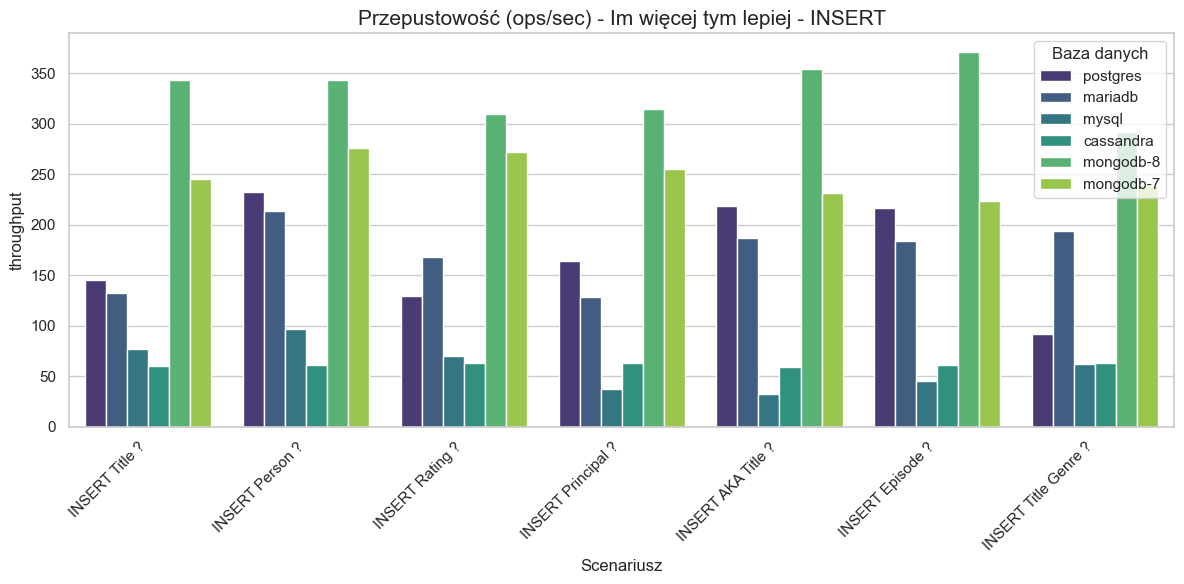

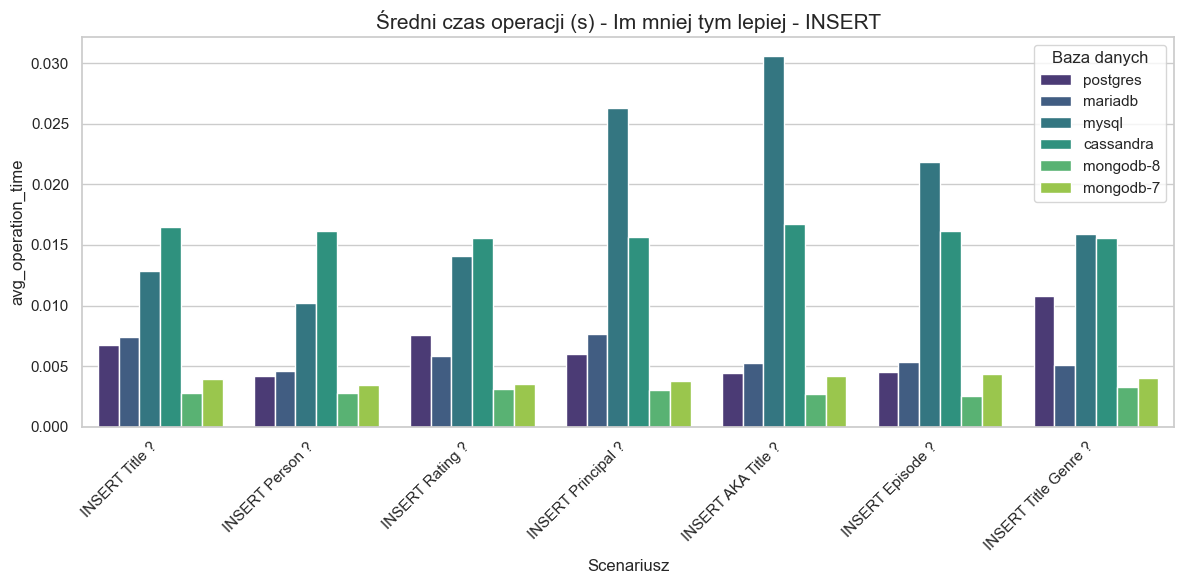

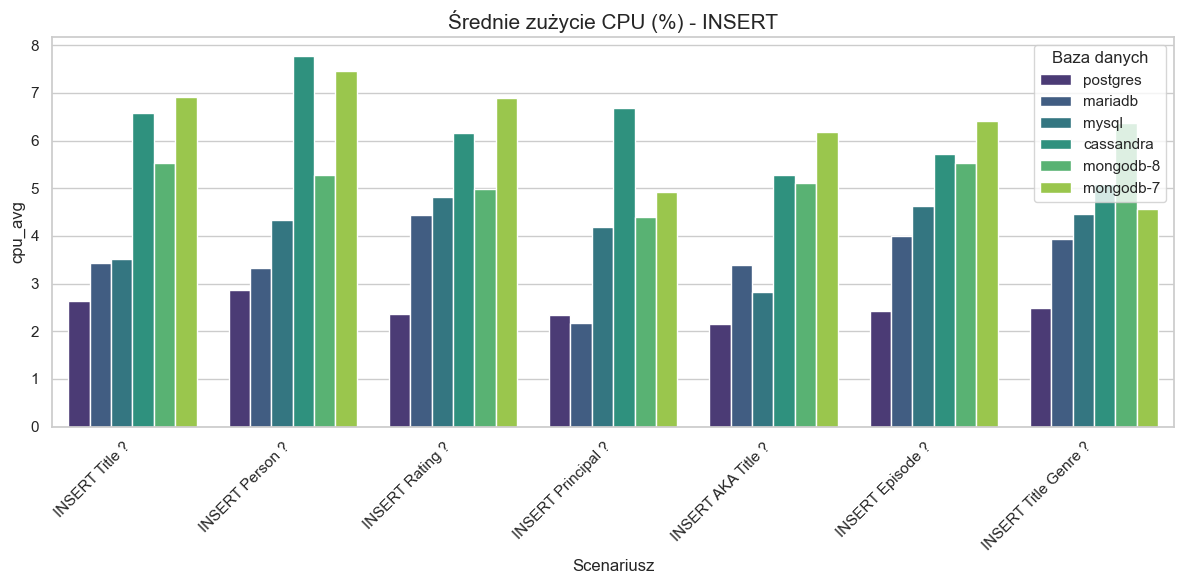

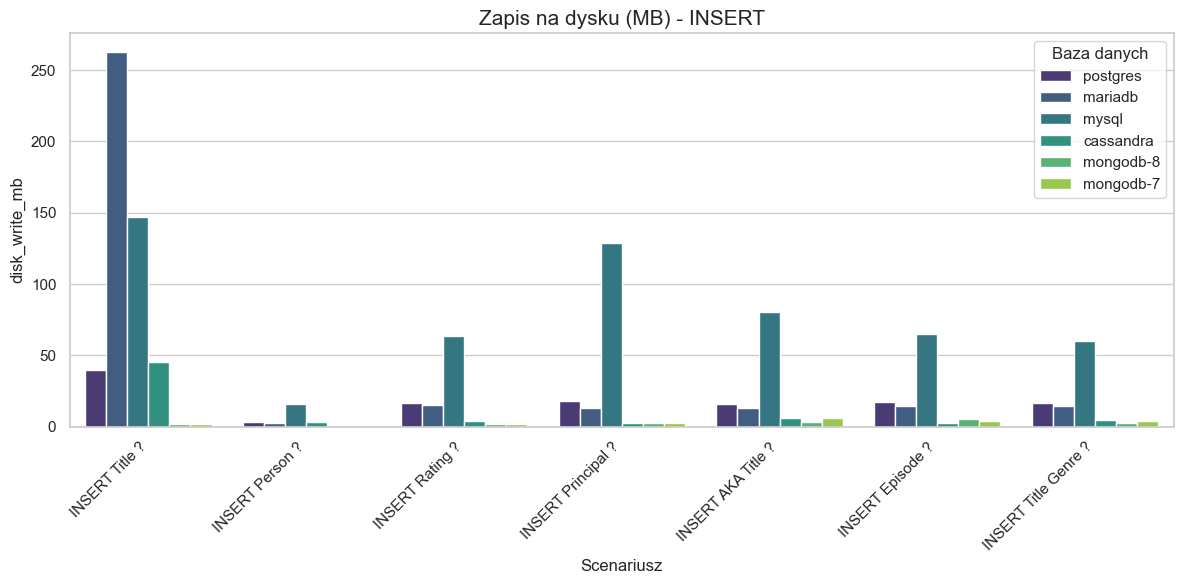

--- Generowanie wykresów dla operacji typu: SELECT ---


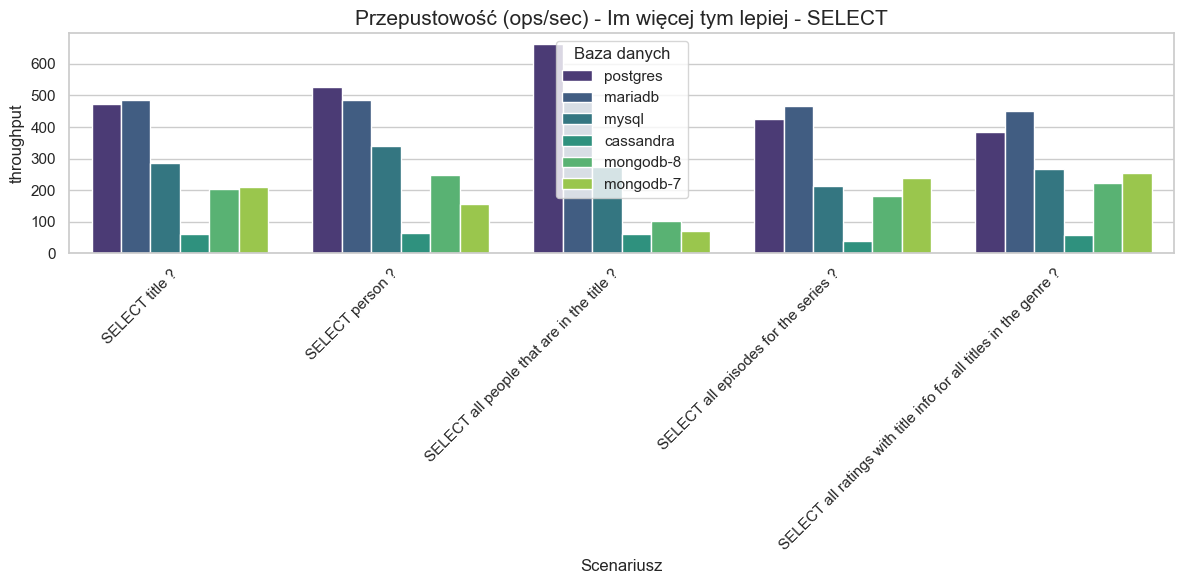

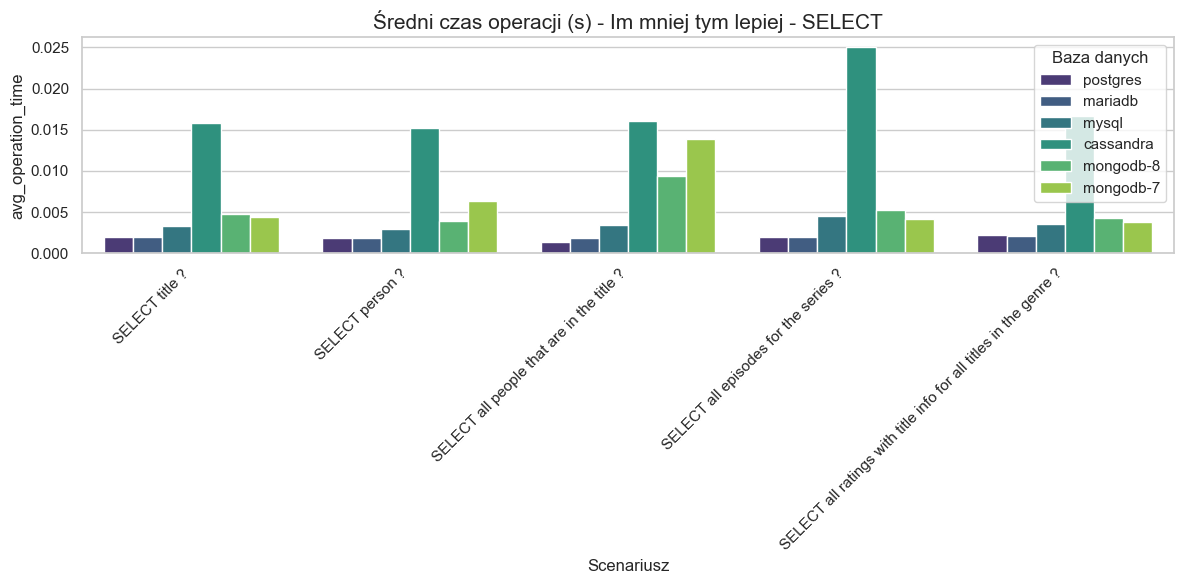

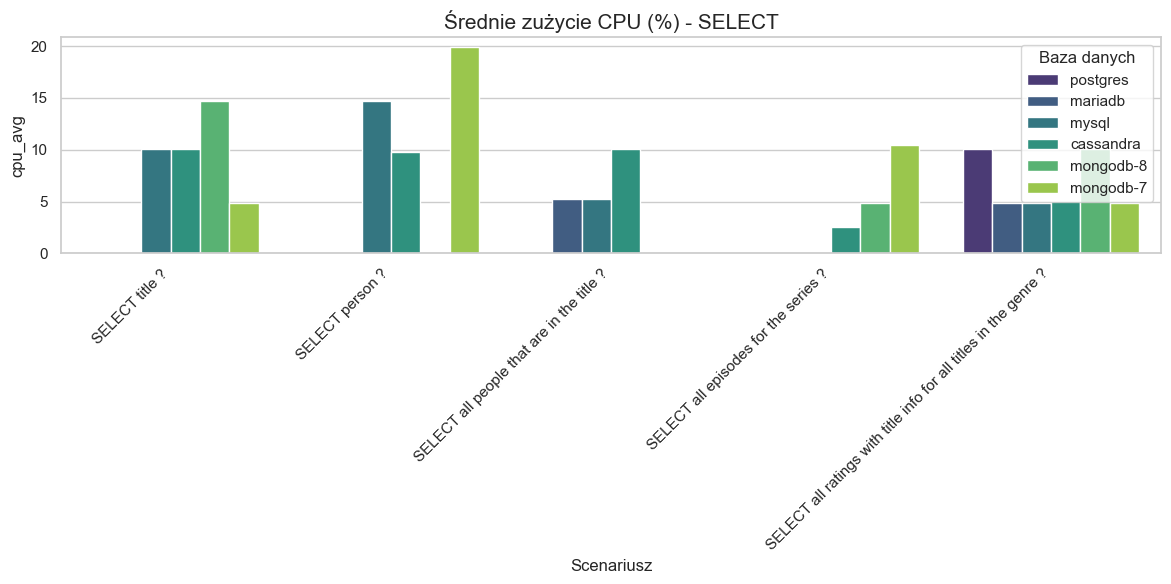

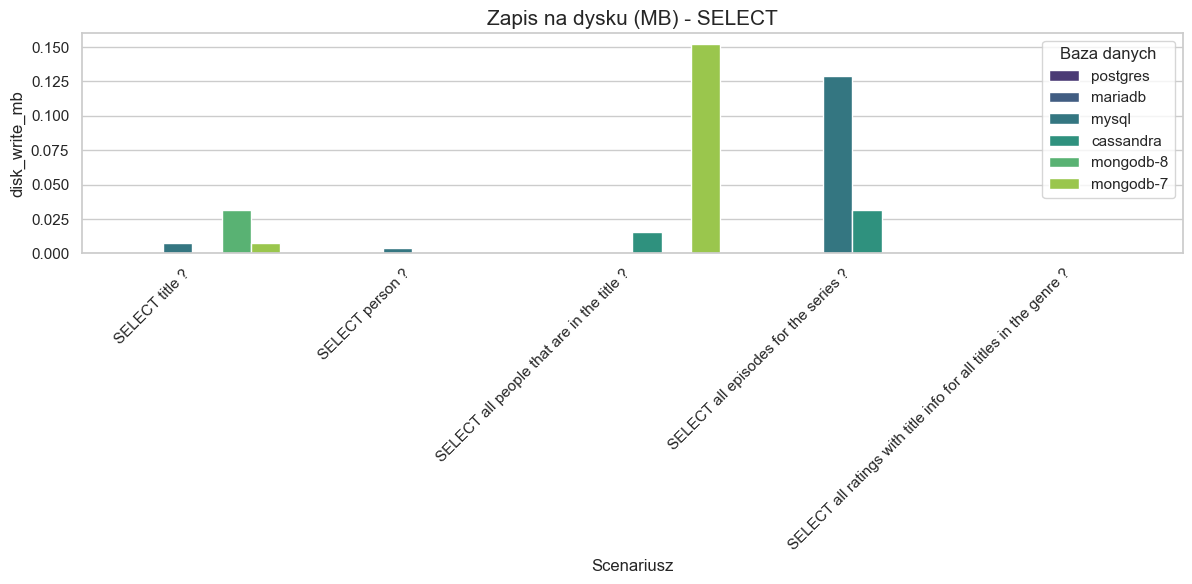

--- Generowanie wykresów dla operacji typu: UPDATE ---


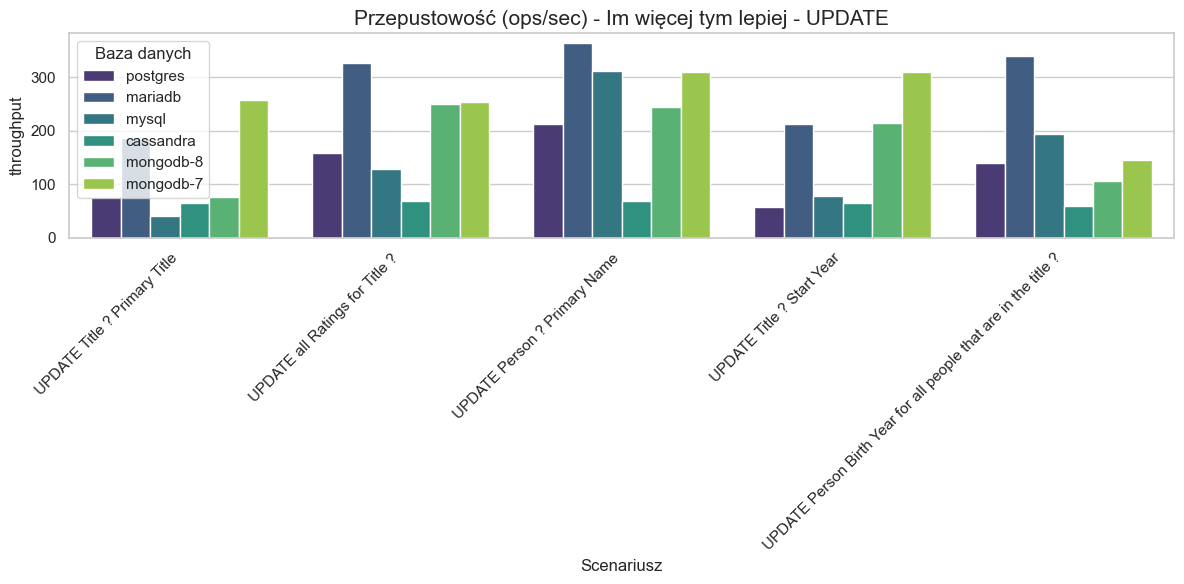

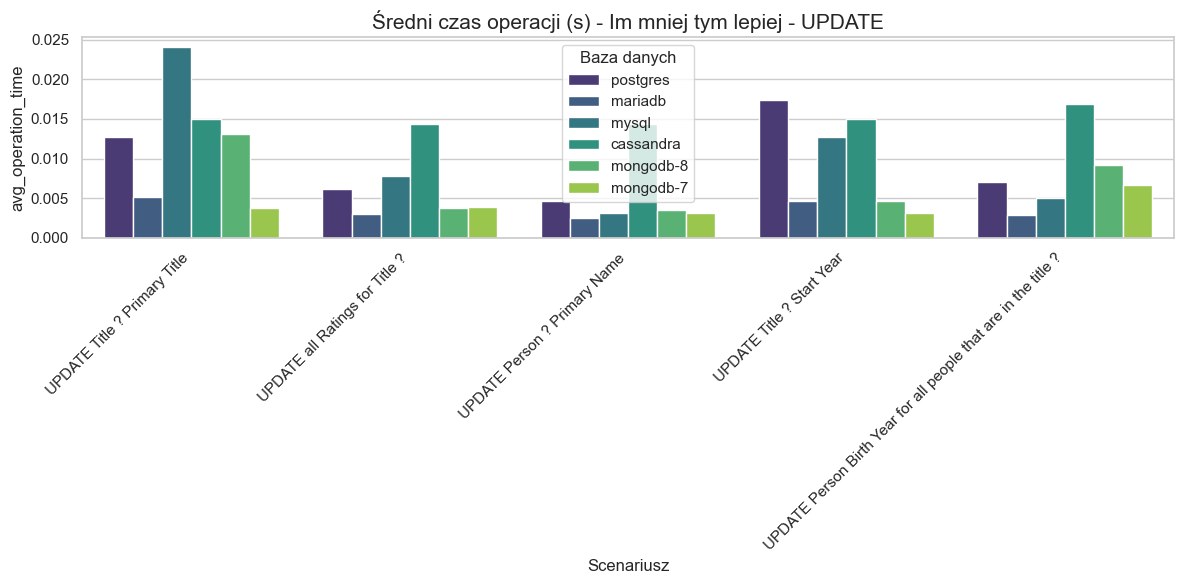

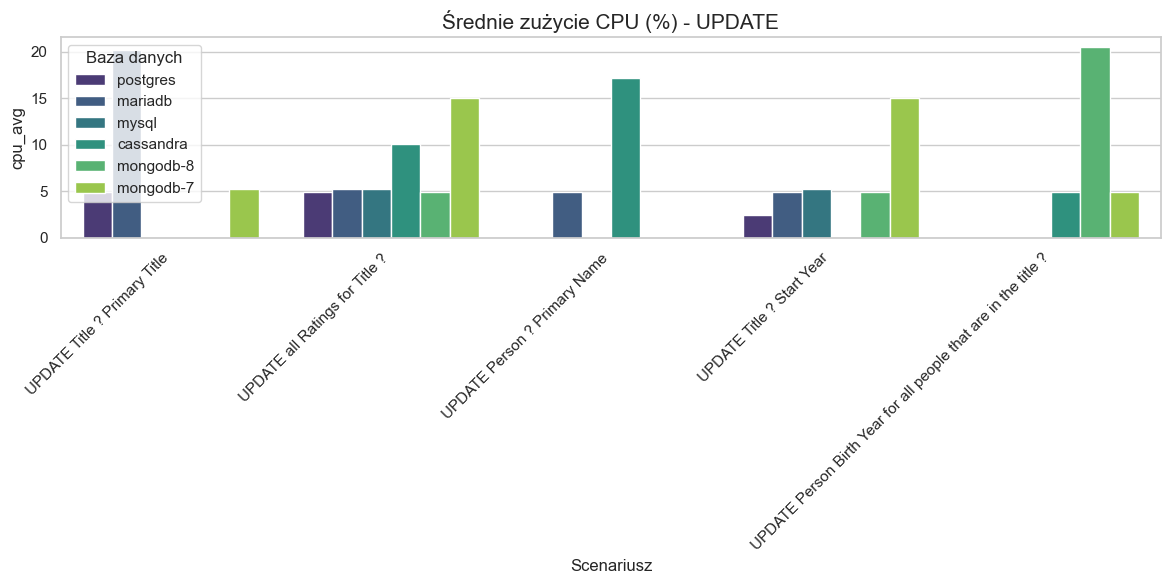

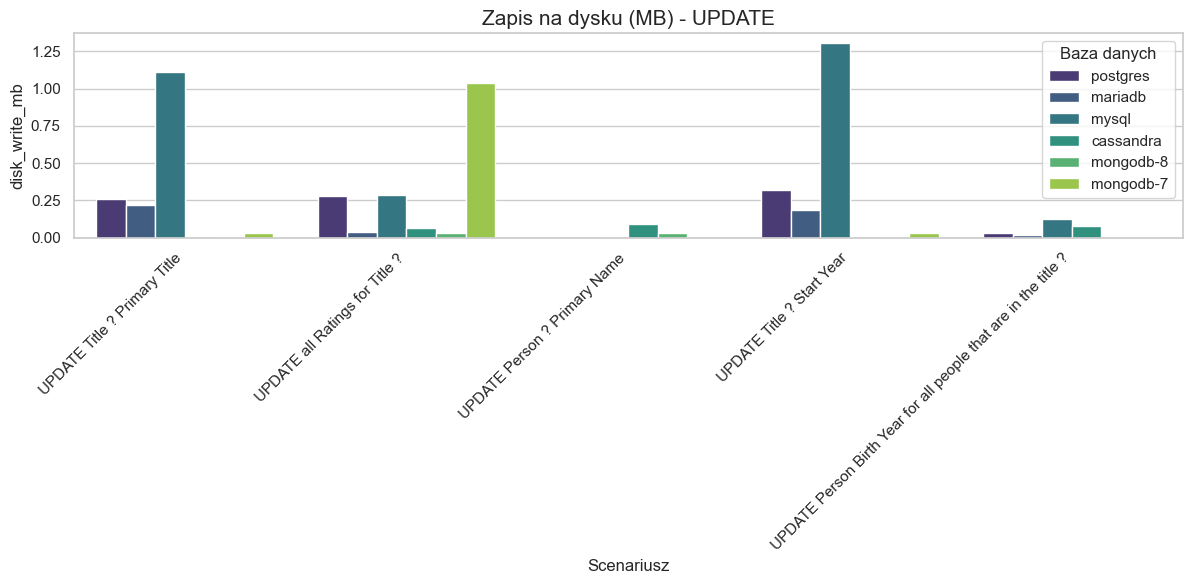

--- Generowanie wykresów dla operacji typu: DELETE ---


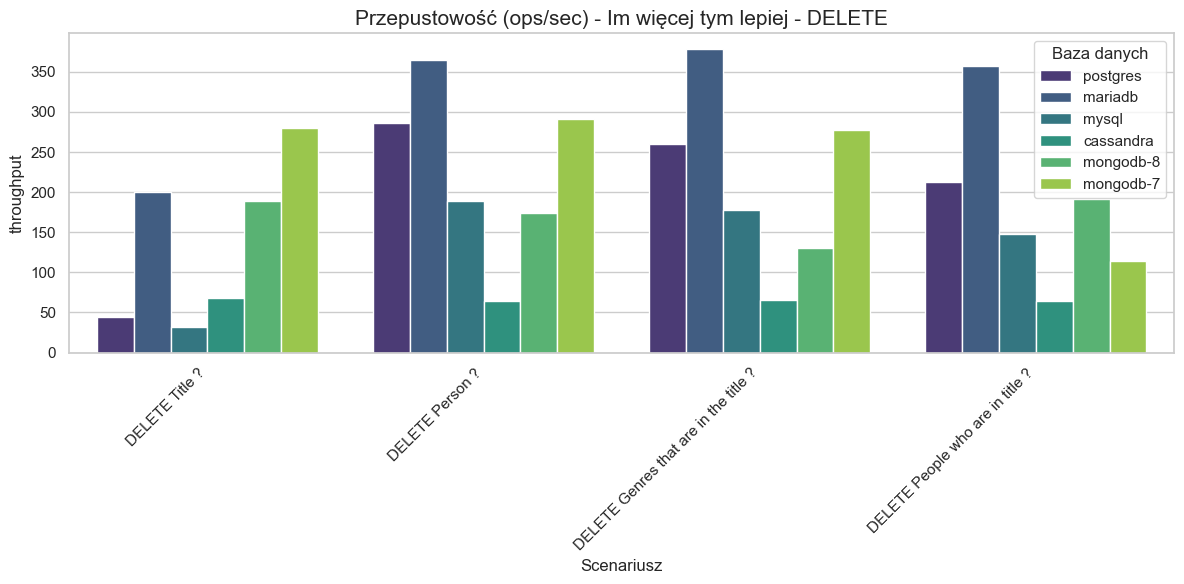

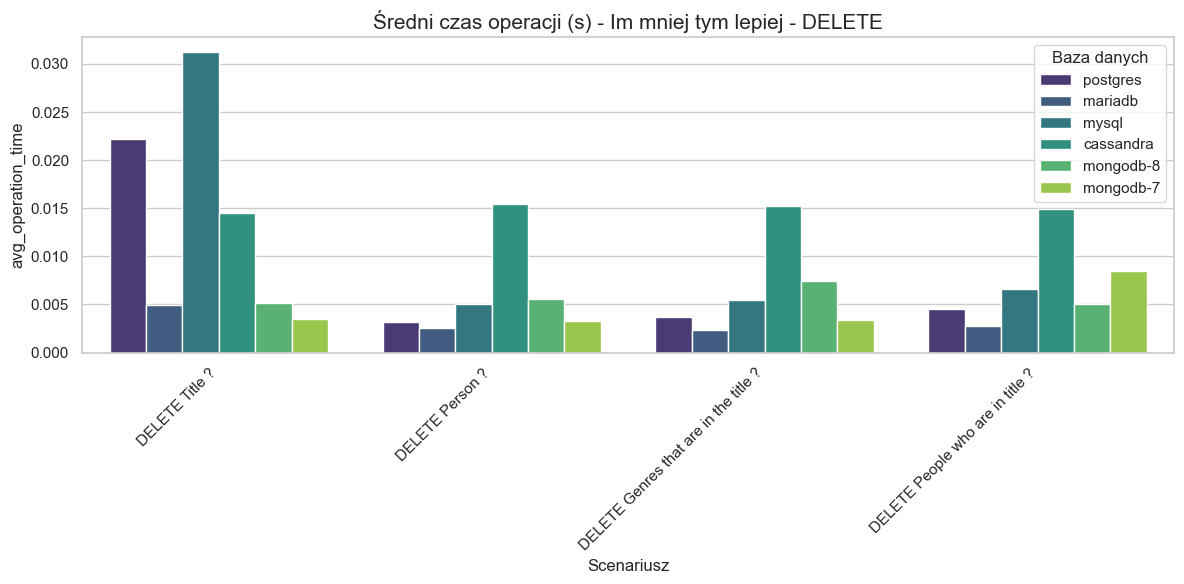

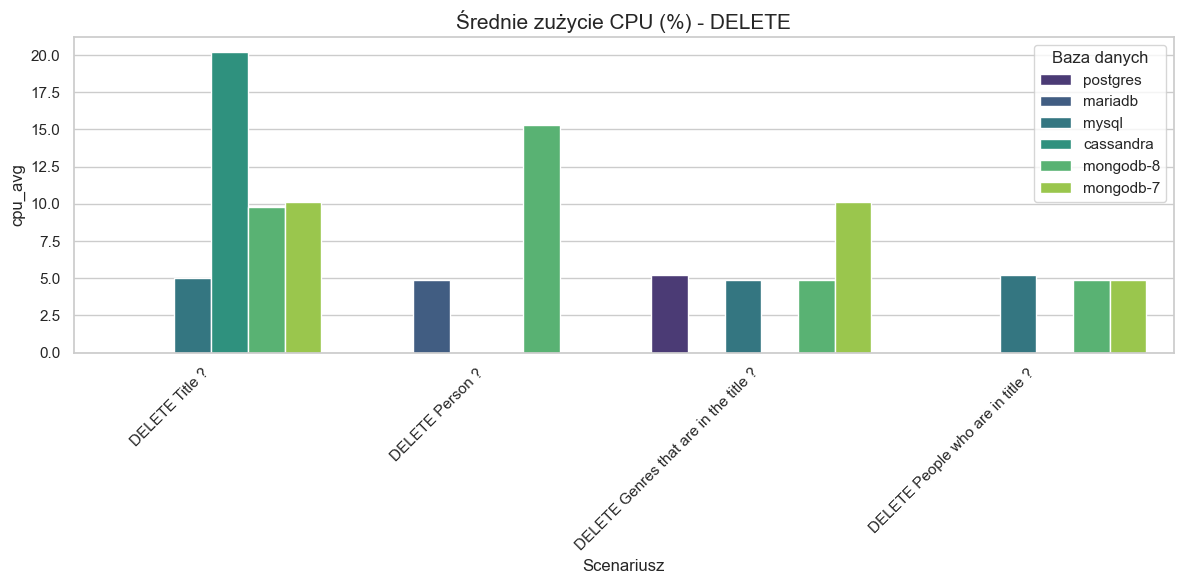

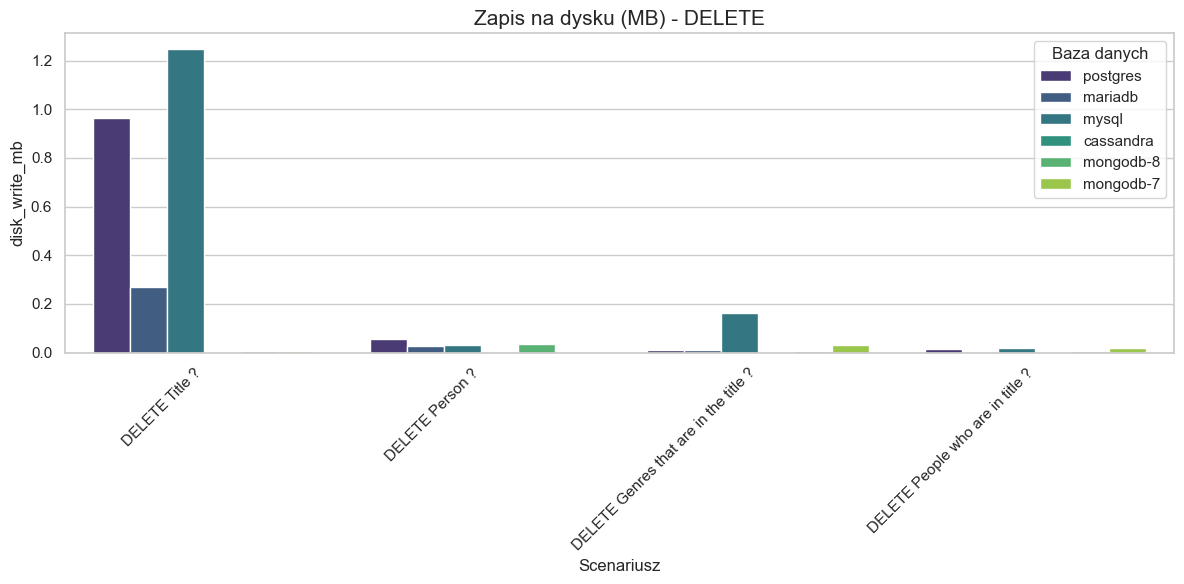

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_benchmark_charts(file_path):
    # 1. Wczytanie danych
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Błąd: Nie znaleziono pliku {file_path}")
        return

    # 2. Wyciągnięcie typu operacji (pierwsze słowo ze scenariusza) w celu grupowania
    # Np. "INSERT Title ?" -> "INSERT"
    df['op_type'] = df['scenario'].apply(lambda x: x.split()[0])
    
    # Ustawienie stylu wykresów
    sns.set_theme(style="whitegrid")
    
    # Lista unikalnych typów operacji (INSERT, SELECT, itp.)
    operation_types = df['op_type'].unique()
    
    # Metryki, które chcemy wizualizować
    metrics = [
        ('throughput', 'Przepustowość (ops/sec) - Im więcej tym lepiej'),
        ('avg_operation_time', 'Średni czas operacji (s) - Im mniej tym lepiej'),
        ('cpu_avg', 'Średnie zużycie CPU (%)'),
        ('disk_write_mb', 'Zapis na dysku (MB)')
    ]

    # 3. Generowanie wykresów
    for op_type in operation_types:
        subset = df[df['op_type'] == op_type]
        
        # Pomijamy puste grupy
        if subset.empty:
            continue
            
        print(f"--- Generowanie wykresów dla operacji typu: {op_type} ---")
        
        # Dla każdej metryki osobny wykres w ramach danego typu operacji
        for metric, title in metrics:
            plt.figure(figsize=(12, 6))
            
            chart = sns.barplot(
                data=subset,
                x='scenario',
                y=metric,
                hue='database',
                palette='viridis' 
            )
            
            plt.title(f"{title} - {op_type}", fontsize=15)
            plt.xlabel("Scenariusz")
            plt.ylabel(metric)
            plt.xticks(rotation=45, ha='right') # Obrót etykiet dla czytelności
            plt.legend(title='Baza danych')
            plt.tight_layout()
            plt.show()

# --- PRZYKŁAD UŻYCIA ---
# Podmień poniższą ścieżkę na nazwę swojego pliku, np. 'wyniki.csv' lub zmienną ze ścieżką
file_path = 'data/processed_1000/merged_results.csv' 

# Jeśli masz dane w zmiennej lub plik lokalnie, wywołaj funkcję:
generate_benchmark_charts(file_path)